# Set up

In [15]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_validate, KFold, StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, accuracy_score


train_initial_df = pd.read_csv("./train.csv", encoding="cp1251", sep=";")
test_df = pd.read_csv("./test.csv", encoding="cp1251", sep=";")

In [11]:
test_df

,CAR,PV,nbki,ind_noNbki,equi,ind_noEqui,def90_365
0,б/у,0.1514,744,0,724,0,0
1,новый,0.3305,0,1,0,1,0
2,новый,0.3034,0,1,748,0,0
3,б/у,0.2000,529,0,690,0,0
4,новый,0.1002,566,0,443,0,0
...,...,...,...,...,...,...,...
14705,б/у,0.4386,668,0,483,0,0
14706,новый,0.1500,0,1,0,1,0
14707,б/у,0.3000,715,0,0,1,0
14708,новый,0.4615,675,0,508,0,0


In [2]:
def enc_cat_features(X, cat_features):
    enc = OneHotEncoder(handle_unknown='ignore')
    enc_cat_vars = pd.DataFrame(enc.fit_transform(X[cat_features]).toarray(), columns=enc.get_feature_names_out())
    encoded = X.join(enc_cat_vars).drop(columns=cat_features)
    return encoded


def minmax_scale_num_features(X, num_features):
    scaler = MinMaxScaler()
    minmax_num_vars = pd.DataFrame(scaler.fit_transform(X[num_features]), columns=scaler.get_feature_names_out())
    scaled = X.drop(columns=num_features).join(minmax_num_vars)
    return scaled


def standard_scale_num_features(X, num_features):
    scaler = StandardScaler()
    std_num_vars = pd.DataFrame(scaler.fit_transform(X[num_features]), columns=scaler.get_feature_names_out())
    scaled = X.drop(columns=num_features).join(std_num_vars)
    return scaled


def cv_score_gini(cls, X, y, cv=5):
    cv_scores = cross_validate(cls, X, y, cv=cv, scoring='roc_auc', return_train_score=True, return_estimator=True)

    gini_train = 2*(cv_scores['train_score'].mean())-1
    gini_test = 2*(cv_scores['test_score'].mean())-1

    return [gini_train, gini_test]


def get_intervals(y, prds, step=0.02):
    assert 1 / step - int(1 / step) == 0, "1 / step must be a natural number"

    intervals = list()
    prds_df = pd.DataFrame({"y": y, "prob": prds})
    bins = pd.IntervalIndex.from_tuples([(float("{:.2f}".format(i)), float("{:.2f}".format(i+step))) for i \
                                         in np.arange(0, 1, step)], closed="left")
    prds_df["interval"] = pd.cut(prds_df["prob"], bins=bins, include_lowest=True)
    for int_ in list(prds_df['interval'].value_counts().index):
        int_df = prds_df[prds_df['interval'] == int_]
        g_c = int_df['y'].value_counts().get(0, 0)
        b_c = int_df['y'].value_counts().get(1, 0)
        intervals.append({"interval":int_, "good": g_c, "bad": b_c})
    intervals.sort(key=lambda x: x['interval'].left)
    intervals_df = pd.DataFrame(intervals, columns=["interval", "good", "bad"])
    return intervals_df


def get_KS_stat(prds, y, step=0.02):
    KS_stat_tab = get_intervals(y, prds, step=step)
    KS_stat_tab["bad_cum_prop"] = 100*(KS_stat_tab["bad"].cumsum() / KS_stat_tab["bad"].sum())
    KS_stat_tab["good_cum_prop"] = 100*(KS_stat_tab["good"].cumsum() / KS_stat_tab["good"].sum())
    KS_stat_tab["KS_stat"] = (KS_stat_tab["bad_cum_prop"] - KS_stat_tab["good_cum_prop"]).abs()
    return KS_stat_tab


def count_mpp_target_accuracy(probas, y, threshold, inverse=False):
    model_labels = pd.DataFrame([1 if i>=threshold else 0 for i in probas], columns=["model_label"])

    if inverse:
        mpp_target = pd.DataFrame(np.where(model_labels["model_label"] != y, 1, 0), columns=["mpp_target"])
    else:
        mpp_target = pd.DataFrame(np.where(model_labels["model_label"] == y, 1, 0), columns=["mpp_target"])

    return mpp_target


def count_gini(probas, y):
    gini = float((2*roc_auc_score(y, probas))-1)
    return gini


def count_neg_pred_val(conf_matrix):
    tn = conf_matrix[1][1]
    fn = conf_matrix[1][0]
    npv = tn / (fn+tn)
    return npv


def count_loss_frac(conf_matrix):
    tn = conf_matrix[1][1]
    fn = conf_matrix[1][0]
    loss_frac = fn / (fn+tn)
    return loss_frac


def plot_gini(train_probas, test_probas, train_y, test_y, labels = ["train", "test"]):
    plt.figure(figsize=(10, 5))
    plt.ylabel("Sensitivity")
    plt.xlabel("1-Specificity")

    train_fpr, train_tpr, _ = roc_curve(train_y, train_probas, pos_label=1)
    test_fpr, test_tpr, _ = roc_curve(test_y, test_probas, pos_label=1)
    
    train_gini = count_gini(train_probas, train_y)
    test_gini = count_gini(test_probas, test_y)

    plt.plot(1-(1-train_fpr), train_tpr, label=f"gini {labels[0]} " + str(train_gini))
    plt.plot(1-(1-test_fpr), test_tpr, label=f"gini {labels[1]} " + str(test_gini))

    plt.legend(loc=0)
    return 0


def apply_threshold(probs, threshold):
    labels = pd.DataFrame([1 if i>=threshold else 0 for i in probs], columns=["labels"]).to_numpy().flatten()
    return labels


def get_folds(df, n_folds, stratified=False):
    if stratified:
        skf = StratifiedKFold(n_splits=n_folds)
        cv_folds = list(skf.split(df, df[target]))
    else:
        kf = KFold(n_splits=n_folds)
        cv_folds = list(kf.split(df))
    folds = [df.iloc[cv_folds[i][1]] for i in range(len(cv_folds))]
    return folds


def predicted_accuracy_score(mpp_accuracy_labels):
    predicted_accuracy = mpp_accuracy_labels.sum() / len(mpp_accuracy_labels)
    return predicted_accuracy


def average(lst):
    list_avarage = sum(lst) / len(lst)
    return list_avarage


def train_test_split_df(df, test_size, random_state=None, reset_index=True):
    train, test = train_test_split(df, test_size=test_size, random_state=random_state)

    if reset_index:
        train.reset_index(inplace=True, drop=True)
        test.reset_index(inplace=True, drop=True)

    return train, test


def cv_gs_score_gini(cls, parameters_grid, X, y, cv=5):
    grid_search = GridSearchCV(cls, parameters_grid, cv=cv, n_jobs=-1, scoring='roc_auc', return_train_score=True)
    grid_search.fit(X, y)

    best_index = grid_search.best_index_
    cv_gs_scores = grid_search.cv_results_

    gini_train = 2*(cv_gs_scores['mean_train_score'][best_index])-1
    gini_test = 2*(cv_gs_scores['mean_test_score'][best_index])-1

    best_parameters = grid_search.best_params_

    return [gini_train, gini_test, best_parameters]


def calculate_threshold(probas, y, step=0.02):
    KS_stat = get_KS_stat(probas, y, step)
    KS_stat_max_values = KS_stat[KS_stat["KS_stat"] == KS_stat["KS_stat"].max()]
    KS_stat_max_values_sorted = KS_stat_max_values.sort_values(by=["interval"], ascending=False).reset_index(drop=True)
    KS_stat_max = KS_stat_max_values_sorted.loc[[0]]

    print("KS stat max:")
    display(KS_stat_max)

    threshold = KS_stat_max["interval"][0].right

    return [threshold, KS_stat]


def prettify_results_df(df):
    def x_transform(x):
        if type(x) == str:
            try:
                return "%.3f" % x
            except:
                if x == "nan":
                    return "-"
                else:
                    return x
        elif type(x) == float:
            if np.isnan(x):
                return "-"
            else:
                return "%.3f" % x

    for col in df.columns:
        df[col] = df[col].map(lambda x: x_transform(x))

    return df

In [3]:
test_size = 0.33
rand_state = 4
cv=int(1/test_size)
cv_gs=5
parameters_tuning=True

print("cv:", cv, "\ncv gs:", cv_gs)

cv: 3 
cv gs: 5


In [4]:
train_df, validation_df = train_test_split_df(train_initial_df, 
                                           test_size=test_size,
                                           random_state=rand_state)

# Data analysis

In [5]:
print("empty values train: ", train_df.isnull().sum().sum())
print("empty values validation: ", validation_df.isnull().sum().sum())
print("empty values test: ", test_df.isnull().sum().sum())

empty values train:  0
empty values validation:  0
empty values test:  0


<AxesSubplot:>

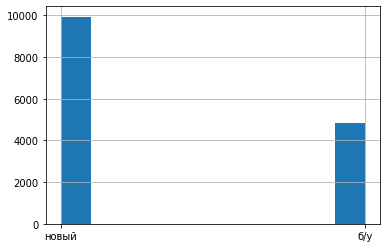

In [6]:
train_df["CAR"].hist()

<AxesSubplot:>

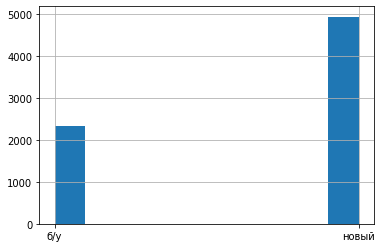

In [7]:
validation_df["CAR"].hist()

<AxesSubplot:>

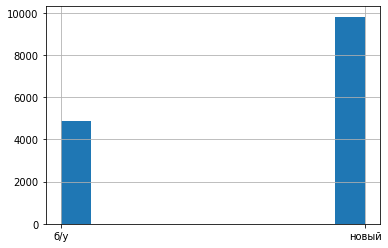

In [8]:
test_df["CAR"].hist()

Text(0.5, 1.0, 'ind_noEqui')

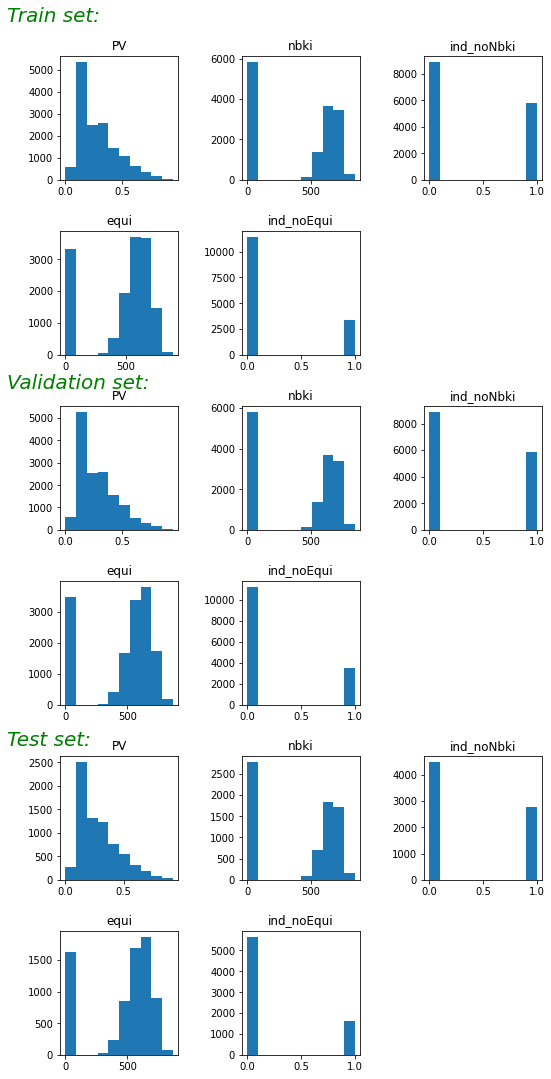

In [9]:
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(8, 15))
fig.tight_layout(pad=3.0)

fig.text(0, 1, 'Train set:', style = 'italic', fontsize = 20, color = "green")
fig.text(0, 0.66, 'Validation set:', style = 'italic', fontsize = 20, color = "green")
fig.text(0, 0.33, 'Test set:', style = 'italic', fontsize = 20, color = "green")

axes[1, 2].set_visible(False)
axes[3, 2].set_visible(False)
axes[5, 2].set_visible(False)

axes[0, 0].hist(train_df['PV'])
axes[0, 0].set_title('PV')

axes[0, 1].hist(train_df['nbki'])
axes[0, 1].set_title('nbki')

axes[0, 2].hist(train_df['ind_noNbki'])
axes[0, 2].set_title('ind_noNbki')

axes[1, 0].hist(train_df['equi'])
axes[1, 0].set_title('equi')

axes[1, 1].hist(train_df['ind_noEqui'])
axes[1, 1].set_title('ind_noEqui')


axes[2, 0].hist(test_df['PV'])
axes[2, 0].set_title('PV')

axes[2, 1].hist(test_df['nbki'])
axes[2, 1].set_title('nbki')

axes[2, 2].hist(test_df['ind_noNbki'])
axes[2, 2].set_title('ind_noNbki')

axes[3, 0].hist(test_df['equi'])
axes[3, 0].set_title('equi')

axes[3, 1].hist(test_df['ind_noEqui'])
axes[3, 1].set_title('ind_noEqui')


axes[4, 0].hist(validation_df['PV'])
axes[4, 0].set_title('PV')

axes[4, 1].hist(validation_df['nbki'])
axes[4, 1].set_title('nbki')

axes[4, 2].hist(validation_df['ind_noNbki'])
axes[4, 2].set_title('ind_noNbki')

axes[5, 0].hist(validation_df['equi'])
axes[5, 0].set_title('equi')

axes[5, 1].hist(validation_df['ind_noEqui'])
axes[5, 1].set_title('ind_noEqui')

# Sets

In [10]:
cat_features = ["CAR"]
num_features = ["PV", "nbki", "ind_noNbki", "equi", "ind_noEqui"]
target = "def90_365"
target_mpp = "mpp_target"

In [11]:
train_initial = enc_cat_features(train_initial_df, cat_features)
train_initial_X = train_initial.drop(columns=[target])
train_initial_y = train_initial[target]


train = enc_cat_features(train_df, cat_features)
train_X = train.drop(columns=[target])
train_y = train_df[target]


validation = enc_cat_features(validation_df, cat_features)
validation_X = validation.drop(columns=[target])
validation_y = validation_df[target]


test = enc_cat_features(test_df, cat_features)
test_X = test.drop(columns=[target])
test_y = test_df[target]

In [12]:
train_initial_df

,CAR,PV,nbki,ind_noNbki,equi,ind_noEqui,def90_365
0,новый,0.1500,648,0,697,0,0
1,новый,0.1992,774,0,587,0,0
2,новый,0.1639,618,0,556,0,0
3,новый,0.1996,721,0,526,0,0
4,б/у,0.2000,561,0,509,0,0
...,...,...,...,...,...,...,...
22059,новый,0.6116,795,0,769,0,0
22060,новый,0.1956,646,0,565,0,0
22061,новый,0.3101,594,0,536,0,0
22062,б/у,0.0000,0,1,0,1,0


In [13]:
train_df

,CAR,PV,nbki,ind_noNbki,equi,ind_noEqui,def90_365
0,новый,0.3000,726,0,687,0,0
1,новый,0.1784,656,0,730,0,0
2,новый,0.3350,0,1,0,1,0
3,б/у,0.2353,731,0,534,0,0
4,б/у,0.3962,640,0,498,0,0
...,...,...,...,...,...,...,...
14777,б/у,0.4029,0,1,739,0,0
14778,б/у,0.1538,0,1,666,0,0
14779,новый,0.2002,0,1,569,0,0
14780,б/у,0.1765,665,0,654,0,0


In [14]:
validation_df

,CAR,PV,nbki,ind_noNbki,equi,ind_noEqui,def90_365
0,б/у,0.0000,544,0,572,0,0
1,новый,0.6009,669,0,0,1,0
2,новый,0.1519,0,1,0,1,0
3,новый,0.1971,443,0,0,1,0
4,новый,0.2106,672,0,545,0,0
...,...,...,...,...,...,...,...
7277,б/у,0.3000,684,0,522,0,1
7278,новый,0.1004,587,0,563,0,0
7279,новый,0.1520,735,0,726,0,0
7280,новый,0.3015,0,1,673,0,0


In [15]:
test_df

,CAR,PV,nbki,ind_noNbki,equi,ind_noEqui,def90_365
0,б/у,0.1514,744,0,724,0,0
1,новый,0.3305,0,1,0,1,0
2,новый,0.3034,0,1,748,0,0
3,б/у,0.2000,529,0,690,0,0
4,новый,0.1002,566,0,443,0,0
...,...,...,...,...,...,...,...
14705,б/у,0.4386,668,0,483,0,0
14706,новый,0.1500,0,1,0,1,0
14707,б/у,0.3000,715,0,0,1,0
14708,новый,0.4615,675,0,508,0,0


# Parameters

In [16]:
lr_parameters_grid = {
    "max_iter": list(range(100, 5100, 300)),
    "penalty": ["l2", "l1"],
    "C": np.logspace(-4, 4, 50),
    "multi_class": ["ovr"],
    "solver": ["lbfgs", "liblinear"]
}

dt_parameters_grid = {
    "class_weight": [None], #def. None
    "min_impurity_decrease": [0.0], #def. 0.0
    "criterion": ["gini"], #def. gini
    "max_depth": list(range(1, 8+1, 1)) + [None], #def. None
    "min_samples_split": [2, 10], #def. 2
    "min_samples_leaf": [1, 2], #def. 1
    "max_features": [None, "sqrt"],
    "random_state": [rand_state]
}

rf_parameters_grid = {
    "max_features": [None, "sqrt"],
    "max_samples": [None, math.ceil(0.632*train_X.shape[0])], #def. None
    "min_samples_split": [float(1), 2, 10, 20, 50, 100], #def. 2
    "n_estimators": list(map(int, np.logspace(np.log10(1000), np.log10(100), 10))), #def. 100,
    #"max_depth": list(range(1, 17, 1)), #long.
    "max_depth": list(range(1, 8+1, 1)) + [None],
    "random_state": [rand_state]
}

xgb_parameters_grid = {
    "n_estimators": list(map(int, np.logspace(np.log10(1000), np.log10(100), 10))), #def. 100,
    "max_depth": list(range(1, 8+1, 1)) + [None],
    "learning_rate": [0.05, 0.02, 0.1, 0.2, 0.3, 0.5], #def. 0.1
    "subsample": [1, math.ceil(0.632*train_X.shape[0])],
    "gamma": [0.0, 0.3, 0.5, 1, 3, 5], #def. 0
    "seed": [rand_state]
}

# Main model start

## Set up

In [17]:
def main_model_learn(cls, params_grid, 
                     X_train, y_train, 
                     X_train_initial, y_train_initial, 
                     cv, cv_gs, 
                     params_tuning=True):
    # reminder: nested cv
    if params_tuning:
        # grid search cross-validation
        mm_cv_gs_train_scores, mm_cv_gs_test_scores, mm_gs_best_params = cv_gs_score_gini(cls, params_grid, train_X, train_y, cv=cv_gs)
        print("\n\tMain model parameters tuning:")
        print("\nCV GS train gini mean:", "%.3f" % mm_cv_gs_train_scores)
        print("CV GS validation gini mean:", "%.3f" % mm_cv_gs_test_scores)
        print(f"\tgs cv is {cv_gs}")
        print("\nBest parameters:\n", mm_gs_best_params)

        mm = cls.set_params(**mm_gs_best_params)
    else:
        mm = cls
        mm_cv_gs_train_scores = None
        mm_cv_gs_test_scores = None
        mm_gs_best_params = None

    # Learning
    mm.fit(X_train, y_train)

    # Cross-validation
    mm_cv_train_scores, mm_cv_test_scores = cv_score_gini(mm, X_train_initial, y_train_initial, cv=cv)
    print("\n\tMain model learning:")
    print("CV train gini mean:", "%.3f" % mm_cv_train_scores)
    print("CV validation gini mean:", "%.3f" % mm_cv_test_scores)
    print(f"\tcv is {cv}")

    print("\n\tFit parameters:\n", mm.get_params())

    return [mm, [mm_cv_gs_train_scores, mm_cv_gs_test_scores,
                 mm_cv_train_scores, mm_cv_test_scores]]


def apply_main_model(mm, X_train, X_val, X_test):
    mm_train_probas = mm.predict_proba(X_train)[:,1]
    mm_validation_probas = mm.predict_proba(X_val)[:,1]
    mm_test_probas = mm.predict_proba(X_test)[:,1]

    return [mm_train_probas, mm_validation_probas, mm_test_probas]


def count_sets_gini(train_probas, validation_probas, test_probas, y_train, y_val, y_test):    
    mm_train_gini = count_gini(train_probas, y_train)
    mm_validation_gini = count_gini(validation_probas, y_val)
    mm_test_gini = count_gini(test_probas, y_test)
    print("\ngini train:", "%.3f" % mm_train_gini)
    print("gini validation:", "%.3f" % mm_validation_gini)

    print("\ngini test:", "%.3f" % mm_test_gini, "\n")

    plot_gini(train_probas, validation_probas, y_train, y_val, labels=["train", "validation"])
    plot_gini(train_probas, test_probas, y_train, y_test, labels=["train", "test"])

    return [mm_train_gini, mm_validation_gini, mm_test_gini]

In [18]:
mm_results_index = [
    "CV GS train gini",
    "CV GS val gini",
    "CV train gini",
    "CV val gini",
    "train gini",
    "val gini",
    "test gini",
    "tp",
    "fp",
    "fn",
    "tn"
]

mm_results_df = pd.DataFrame(index=mm_results_index)

## Logistic regression

C:\Program Files\Python310\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
4250 fits failed out of a total of 17000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4250 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Program Files\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python310\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python310\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise V


	Main model parameters tuning:

CV GS train gini mean: 0.647
CV GS validation gini mean: 0.644
	gs cv is 5

Best parameters:
 {'C': 1048.1131341546852, 'max_iter': 4600, 'multi_class': 'ovr', 'penalty': 'l1', 'solver': 'liblinear'}

	Main model learning:
CV train gini mean: 0.646
CV validation gini mean: 0.638
	cv is 3

	Fit parameters:
 {'C': 1048.1131341546852, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 4600, 'multi_class': 'ovr', 'n_jobs': None, 'penalty': 'l1', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

gini train: 0.647
gini validation: 0.636

gini test: 0.636 

CPU times: total: 8.66 s
Wall time: 2min 41s


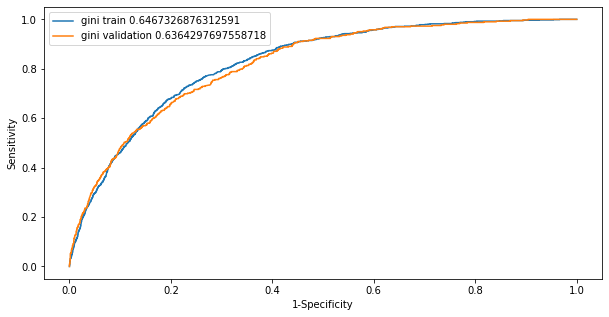

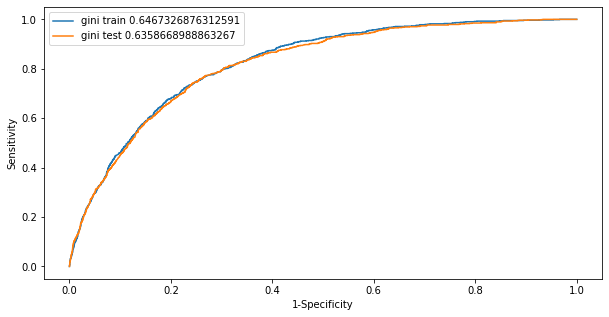

In [19]:
%%time


lr = LogisticRegression(max_iter=800)
lr, lr_learn_scores = main_model_learn(lr, lr_parameters_grid,
                                       train_X, train_y,
                                       train_initial_X, train_initial_y,
                                       cv, cv_gs,
                                       params_tuning=parameters_tuning)

lr_train_probas, lr_validation_probas, lr_test_probas = apply_main_model(lr, train_X, validation_X, test_X)
lr_train_gini, lr_validation_gini, lr_test_gini = count_sets_gini(lr_train_probas, lr_validation_probas, lr_test_probas,
                                                                  train_y, validation_y, test_y)

In [20]:
lr_train_threshold, train_KS_stat_lr = calculate_threshold(lr_train_probas, train_y, 0.02)

# print("Lr full ks stat:")
# display(train_KS_stat_lr)

#lr_train_threshold = 0.06

KS stat max:


,interval,good,bad,bad_cum_prop,good_cum_prop,KS_stat
0,"[0.04, 0.06)",1976,102,24.939759,74.820814,49.881055


In [21]:
lr_test_labels = apply_threshold(lr_test_probas, lr_train_threshold)
lr_confusion_matrix = [list(r) for r in confusion_matrix(test_y, lr_test_labels)]
print("confusion.matrix:", lr_confusion_matrix[0], lr_confusion_matrix[1], sep="\n")

mm_results_df["lr"] = lr_learn_scores + [lr_train_gini, lr_validation_gini, lr_test_gini] + lr_confusion_matrix[0] + lr_confusion_matrix[1]

confusion.matrix:
[10372, 3466]
[221, 651]


## СART


	Main model parameters tuning:

CV GS train gini mean: 0.648
CV GS validation gini mean: 0.588
	gs cv is 5

Best parameters:
 {'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 2, 'random_state': 4}

	Main model learning:
CV train gini mean: 0.652
CV validation gini mean: 0.583
	cv is 3

	Fit parameters:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 4, 'splitter': 'best'}

gini train: 0.645
gini validation: 0.597

gini test: 0.590 

CPU times: total: 469 ms
Wall time: 1.26 s


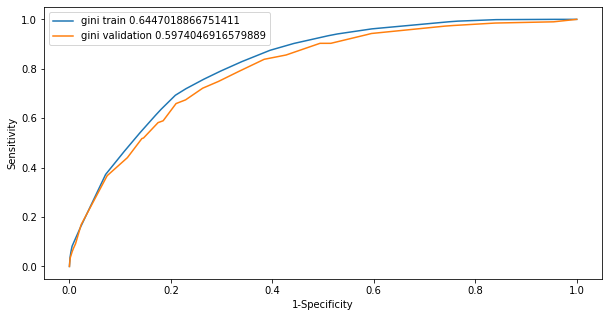

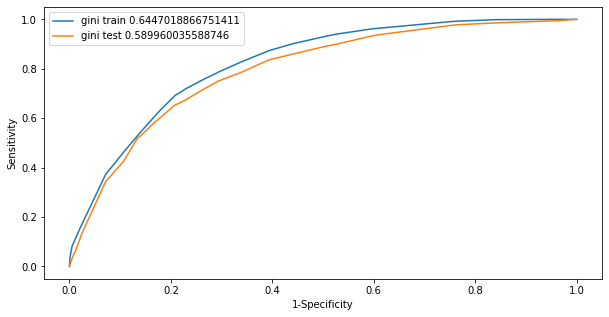

In [22]:
%%time


dt = DecisionTreeClassifier(random_state=rand_state)
dt, dt_learn_scores = main_model_learn(dt, dt_parameters_grid,
                                       train_X, train_y,
                                       train_initial_X, train_initial_y,
                                       cv, cv_gs,
                                       params_tuning=parameters_tuning)

dt_train_probas, dt_validation_probas, dt_test_probas = apply_main_model(dt, train_X, validation_X, test_X)
dt_train_gini, dt_validation_gini, dt_test_gini = count_sets_gini(dt_train_probas, dt_validation_probas, dt_test_probas,
                                                                  train_y, validation_y, test_y)

In [23]:
dt_train_threshold, train_KS_stat_dt = calculate_threshold(dt_train_probas, train_y, 0.02)

# print("Dt full ks stat:")
# display(train_KS_stat_dt)

#dt_train_threshold = 0.06

KS stat max:


,interval,good,bad,bad_cum_prop,good_cum_prop,KS_stat
0,"[0.04, 0.06)",1819,97,24.216867,73.502007,49.285139


In [24]:
dt_test_labels = apply_threshold(dt_test_probas, dt_train_threshold)
dt_confusion_matrix = [list(r) for r in confusion_matrix(test_y, dt_test_labels)]
print("confusion.matrix:", dt_confusion_matrix[0], dt_confusion_matrix[1], sep="\n")

mm_results_df["dt"] = dt_learn_scores + [dt_train_gini, dt_validation_gini, dt_test_gini] + dt_confusion_matrix[0] + dt_confusion_matrix[1]

confusion.matrix:
[10239, 3599]
[251, 621]


## Random forest

rf Breiman samp size 9343

	Main model parameters tuning:

CV GS train gini mean: 0.740
CV GS validation gini mean: 0.638
	gs cv is 5

Best parameters:
 {'max_depth': 6, 'max_features': 'sqrt', 'max_samples': 9343, 'min_samples_split': 100, 'n_estimators': 464, 'random_state': 4}

	Main model learning:
CV train gini mean: 0.733
CV validation gini mean: 0.636
	cv is 3

	Fit parameters:
 {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 6, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': 9343, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 100, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 464, 'n_jobs': None, 'oob_score': False, 'random_state': 4, 'verbose': 0, 'warm_start': False}

gini train: 0.726
gini validation: 0.639

gini test: 0.631 

CPU times: total: 31.5 s
Wall time: 1h 7min 21s


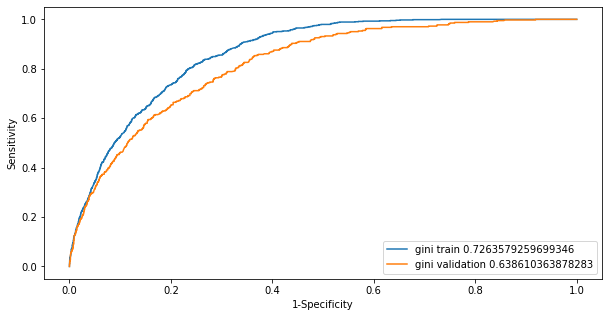

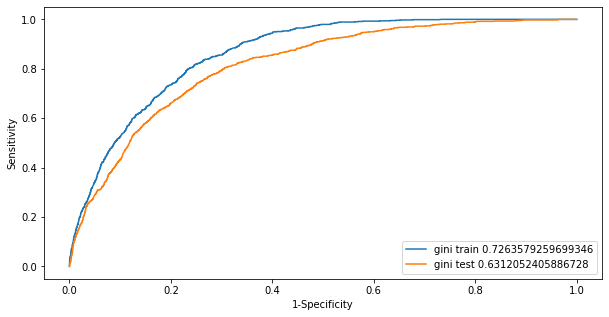

In [25]:
%%time


print("rf Breiman samp size", math.ceil(0.632*train_X.shape[0]))

rf = RandomForestClassifier(n_estimators=100, random_state=rand_state)
rf, rf_learn_scores = main_model_learn(rf, rf_parameters_grid,
                                       train_X, train_y,
                                       train_initial_X, train_initial_y,
                                       cv, cv_gs,
                                       params_tuning=parameters_tuning)

rf_train_probas, rf_validation_probas, rf_test_probas = apply_main_model(rf, train_X, validation_X, test_X)
rf_train_gini, rf_validation_gini, rf_test_gini = count_sets_gini(rf_train_probas, rf_validation_probas, rf_test_probas,
                                                                  train_y, validation_y, test_y)

In [26]:
rf_train_threshold, train_KS_stat_rf = calculate_threshold(rf_train_probas, train_y, 0.02)

# print("Rf full ks stat:")
# display(train_KS_stat_rf)

#rf_train_threshold = 0.18

KS stat max:


,interval,good,bad,bad_cum_prop,good_cum_prop,KS_stat
0,"[0.04, 0.06)",2022,87,15.180723,71.824828,56.644105


In [27]:
rf_test_labels = apply_threshold(rf_test_probas, rf_train_threshold)
rf_confusion_matrix = [list(r) for r in confusion_matrix(test_y, rf_test_labels)]
print("confusion.matrix:", rf_confusion_matrix[0], rf_confusion_matrix[1], sep="\n")

mm_results_df["rf"] = rf_learn_scores + [rf_train_gini, rf_validation_gini, rf_test_gini] + rf_confusion_matrix[0] + rf_confusion_matrix[1]

confusion.matrix:
[9850, 3988]
[192, 680]


## XG Boost

C:\Program Files\Python310\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
16200 fits failed out of a total of 32400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
16200 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Program Files\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python310\lib\site-packages\xgboost\core.py", line 532, in inner_f
    return f(**kwargs)
  File "C:\Program Files\Python310\lib\site-packages\xgboost\sklearn.py", line 1400, in fit
    self._Booster = train(
  File "C:\Program Files\Python310\lib\site-packages\xgboost\co


	Main model parameters tuning:

CV GS train gini mean: 0.663
CV GS validation gini mean: 0.637
	gs cv is 5

Best parameters:
 {'gamma': 0.0, 'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 774, 'seed': 4, 'subsample': 1}

	Main model learning:
CV train gini mean: 0.663
CV validation gini mean: 0.624
	cv is 3

	Fit parameters:
 {'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': 0.5, 'booster': 'gbtree', 'callbacks': None, 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'gamma': 0.0, 'gpu_id': -1, 'grow_policy': 'depthwise', 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.05, 'max_bin': 256, 'max_cat_to_onehot': 4, 'max_delta_step': 0, 'max_depth': 1, 'max_leaves': 0, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 774, 'n_jobs': 0, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state':

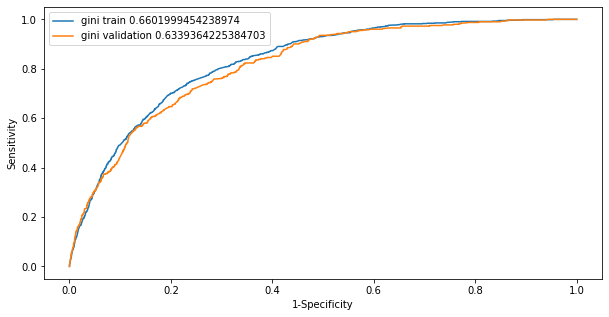

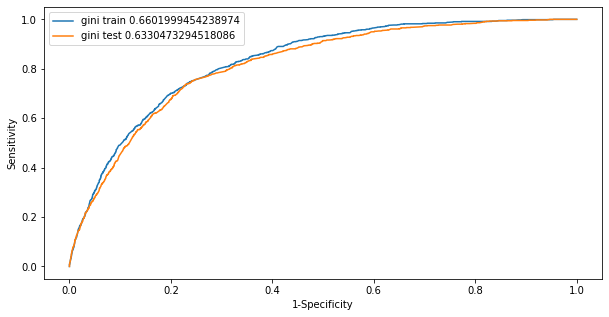

In [28]:
%%time


xgb = XGBClassifier(n_estimators=100, seed=rand_state)
xgb, xgb_learn_scores = main_model_learn(xgb, xgb_parameters_grid,
                                         train_X, train_y,
                                         train_initial_X, train_initial_y,
                                         cv, cv_gs,
                                         params_tuning=parameters_tuning)

xgb_train_probas, xgb_validation_probas, xgb_test_probas = apply_main_model(xgb, train_X, validation_X, test_X)
xgb_train_gini, xgb_validation_gini, xgb_test_gini = count_sets_gini(xgb_train_probas, xgb_validation_probas, xgb_test_probas,
                                                                     train_y, validation_y, test_y)

In [29]:
xgb_train_threshold, train_KS_stat_xgb = calculate_threshold(xgb_train_probas, train_y, 0.02)

# print("XGb full ks stat:")
# display(train_KS_stat_xgb)

#xgb_train_threshold = 0.18

KS stat max:


,interval,good,bad,bad_cum_prop,good_cum_prop,KS_stat
0,"[0.04, 0.06)",1653,78,22.891566,73.122133,50.230567


In [30]:
xgb_test_labels = apply_threshold(xgb_test_probas, xgb_train_threshold)
xgb_confusion_matrix = [list(r) for r in confusion_matrix(test_y, xgb_test_labels)]
print("confusion.matrix:", xgb_confusion_matrix[0], xgb_confusion_matrix[1], sep="\n")

mm_results_df["xgb"] = xgb_learn_scores + [xgb_train_gini, xgb_validation_gini, xgb_test_gini] + xgb_confusion_matrix[0] + xgb_confusion_matrix[1]

confusion.matrix:
[10127, 3711]
[203, 669]


## Results

In [31]:
mm_results_df = prettify_results_df(mm_results_df)

mm_results_df

,lr,dt,rf,xgb
CV GS train gini,0.647,0.648,0.740,0.663
CV GS val gini,0.644,0.588,0.638,0.637
CV train gini,0.646,0.652,0.733,0.663
CV val gini,0.638,0.583,0.636,0.624
train gini,0.647,0.645,0.726,0.660
val gini,0.636,0.597,0.639,0.634
test gini,0.636,0.590,0.631,0.633
tp,10372.000,10239.000,9850.000,10127.000
fp,3466.000,3599.000,3988.000,3711.000
fn,221.000,251.000,192.000,203.000


# MPP start

## Set up

In [32]:
mpp_test_size = 0.33
rand_state_mpp = 4
cv_mpp = int(1/mpp_test_size)

inverse_target = False
nfolds = 10

In [33]:
print("mpp train:", round(validation_X.shape[0]*float(1-mpp_test_size)))
print("mpp test:", round(validation_X.shape[0]*mpp_test_size))
print("cv mpp:", cv_mpp)

mpp train: 4879
mpp test: 2403
cv mpp: 3


In [34]:
def mpp_model_learn(cls, params_grid,
                    X_train_mpp, y_train_mpp,
                    X_validation_mpp, y_validation_mpp,
                    cv_mpp, cv_gs,
                    params_tuning=True):
    # reminder: nested cv
    if params_tuning:
        # grid search cross-validation
        mm_mpp_cv_gs_train_mpp_scores, mm_mpp_cv_gs_test_mpp_scores, mm_mpp_gs_best_params = cv_gs_score_gini(cls, params_grid, X_train_mpp, y_train_mpp, cv=cv_gs)
        print("\n\tMPP parameters tuning:")
        print("\nGS CV train gini mean:", "%.3f" % mm_mpp_cv_gs_train_mpp_scores)
        print("GS CV validation gini mean:", "%.3f" % mm_mpp_cv_gs_test_mpp_scores)
        print(f"\tgs cv is {cv_gs}")
        print("\n\tBest parameters:\n", mm_mpp_gs_best_params)

        mpp = cls.set_params(**mm_mpp_gs_best_params)
    else:
        mpp = cls
        mm_mpp_cv_gs_train_mpp_scores = None
        mm_mpp_cv_gs_test_mpp_scores = None
        mm_mpp_gs_best_params = None

    # Learning
    mpp.fit(X_train_mpp, y_train_mpp)

    # Cross-validation
    mm_mpp_cv_train_mpp_scores, mm_mpp_cv_test_mpp_scores = cv_score_gini(mpp, X_validation_mpp, y_validation_mpp, cv=cv_mpp)
    print("\n\tMPP model learning:")
    print("CV train gini mean:", "%.3f" % mm_mpp_cv_train_mpp_scores)
    print("CV test gini mean:", "%.3f" % mm_mpp_cv_test_mpp_scores)
    print(f"\tcv is {cv}")

    print("\nFit parameters:\n", mpp.get_params())

    return [mpp, [mm_mpp_cv_gs_train_mpp_scores, mm_mpp_cv_gs_test_mpp_scores,
                  mm_mpp_cv_train_mpp_scores, mm_mpp_cv_test_mpp_scores]]


def apply_mpp_model(mm_mpp, X_train_mpp, X_test_mpp):
    # Tests
    mpp_train_mpp_probas = mm_mpp.predict_proba(X_train_mpp)[:,1]
    mpp_test_mpp_probas = mm_mpp.predict_proba(X_test_mpp)[:,1]
    
    return [mpp_train_mpp_probas, mpp_test_mpp_probas]


def count_sets_mpp_gini(train_mpp_probas, test_mpp_probas, y_train_mpp, y_test_mpp):
    mpp_train_mpp_gini = count_gini(train_mpp_probas, y_train_mpp)
    mpp_test_mpp_gini = count_gini(test_mpp_probas, y_test_mpp)
    print("\ngini mpp train:", "%.3f" % mpp_train_mpp_gini)
    print("gini mpp test:", "%.3f" % mpp_test_mpp_gini, "\n")

    plot_gini(train_mpp_probas, test_mpp_probas, y_train_mpp, y_test_mpp, labels=["train mpp", "test mpp"])

    return [mpp_train_mpp_gini, mpp_test_mpp_gini]


def sets_test(main_model, mpp, X_train, X_validation, X_test, y_train, y_validation, y_test, main_model_threshold, mpp_threshold, inverse_target=False):
    if not inverse_target:
        mm_mpp_train_probas = mpp.predict_proba(X_train)[:,1]
        mm_mpp_validation_probas = mpp.predict_proba(X_validation)[:,1]
        mm_mpp_test_probas = mpp.predict_proba(X_test)[:,1]
    else:
        mm_mpp_train_probas = 1 - mpp.predict_proba(X_train)[:,1]
        mm_mpp_validation_probas = 1 - mpp.predict_proba(X_validation)[:,1]
        mm_mpp_test_probas = 1 - mpp.predict_proba(X_test)[:,1]

    mm_train_labels = apply_threshold(mm_train_probas, main_model_threshold)
    mm_mpp_train_labels = apply_threshold(mm_mpp_train_probas, mpp_threshold)
    mm_train_accuracy = accuracy_score(y_train, mm_train_labels)
    mm_train_predicted_accuracy = predicted_accuracy_score(mm_mpp_train_labels)
    print("\naccuracy main model train", "%.3f" % mm_train_accuracy)
    print("predicted accuracy train", "%.3f" % mm_train_predicted_accuracy)
    print("diff.", "%.3f" % (mm_train_accuracy - mm_train_predicted_accuracy))

    mm_validation_labels = apply_threshold(mm_validation_probas, main_model_threshold)
    mm_mpp_validation_labels = apply_threshold(mm_mpp_validation_probas, mpp_threshold)
    mm_validation_accuracy = accuracy_score(y_validation, mm_validation_labels)
    mm_validation_predicted_accuracy = predicted_accuracy_score(mm_mpp_validation_labels)
    print("\naccuracy main model validation", "%.3f" % mm_validation_accuracy)
    print("predicted accuracy valdation", "%.3f" % mm_validation_predicted_accuracy)
    print("diff.", "%.3f" % (mm_validation_accuracy - mm_validation_predicted_accuracy))

    mm_test_labels = apply_threshold(mm_test_probas, main_model_threshold)
    mm_mpp_test_labels = apply_threshold(mm_mpp_test_probas, mpp_threshold)
    mm_test_accuracy = accuracy_score(y_test, mm_test_labels)
    mm_test_predicted_accuracy = predicted_accuracy_score(mm_mpp_test_labels)
    print("\naccuracy main model test", "%.3f" % mm_test_accuracy)
    print("predicted accuracy test", "%.3f" % mm_test_predicted_accuracy)
    print("diff.", "%.3f" % (mm_test_accuracy - mm_test_predicted_accuracy))

    return [[mm_train_accuracy, mm_train_predicted_accuracy],
            [mm_validation_accuracy, mm_validation_predicted_accuracy],
            [mm_test_accuracy, mm_test_predicted_accuracy]]


def plot_trend(trend_pairs):
    # plot correct accuracy/predicted accuracy
    x = [i[0]+1 for i in trend_pairs] # folds indicies
    y1 = [i[1] for i in trend_pairs] # correct accuracy
    y2 = [i[2] for i in trend_pairs] # predicted accuracy

    plt.figure(figsize=(10, 5))
    plt.plot(x, y1, label="correct accuracy")
    plt.plot(x, y2, label="predicted accuracy")
    plt.title("model performance trend")
    acc_plot_step=0.05;plt.yticks([float("%.2f" % i) for i in np.arange(0, 1+acc_plot_step, acc_plot_step).tolist()])
    plt.xticks(x)
    plt.xlabel("fold")
    plt.ylabel("accuracy")
    plt.legend(loc=0)
    plt.show()
    return


def recognize_folds(folds, main_model, mpp_model, main_model_threshold, mpp_model_threshold, inverse=False, tprint=False):
    trend_pairs = []

    for i in range(len(folds)):
        fold_X = folds[i].drop(columns=[target])
        fold_y = folds[i][target]

        lr_fold_probas = main_model.predict_proba(fold_X)[:,1]
        lr_mpp_fold_probas = mpp_model.predict_proba(fold_X)[:,1]
        
        if inverse:
            lr_mpp_fold_probas = 1 - mpp_model.predict_proba(fold_X)[:,1]

        lr_fold_labels = apply_threshold(lr_fold_probas, main_model_threshold)
        lr_mpp_fold_labels = apply_threshold(lr_mpp_fold_probas, mpp_model_threshold)

        lr_fold_accuracy = accuracy_score(fold_y, lr_fold_labels)
        lr_mpp_fold_predicted_accuracy = predicted_accuracy_score(lr_mpp_fold_labels)

        trend_pairs.append(tuple([i, lr_fold_accuracy, lr_mpp_fold_predicted_accuracy]))

        if tprint:
            print(f"\nlr accuracy fold {i+1}:", "%.3f" % lr_fold_accuracy)
            print(f"lr mpp predicted accuracy fold {i+1}:", "%.3f" % lr_mpp_fold_predicted_accuracy)
    trend_pairs.sort(key=lambda x: x[0])

    return trend_pairs


def folds_test(folds, main_model, mpp_model, main_model_threshold, mpp_threshold, inverse_target=False):
    trend_pairs = recognize_folds(folds, main_model, mpp_model, main_model_threshold, mpp_threshold, inverse=inverse_target)
    plot_trend(trend_pairs) 
    return trend_pairs


def count_accuracy_loss(trend_pairs, loss="squared"):
    if loss == "squared":
        accuracy_loss = sum([(i[1]-i[2])**2 for i in trend_pairs])
    elif loss == "abs":
        accuracy_loss = sum([abs(i[1]-i[2]) for i in trend_pairs])
    elif loss == "msquared":
        squared_diffs = [(i[1]-i[2])**2 for i in trend_pairs]
        accuracy_loss = sum(squared_diffs) / len(squared_diffs)
    elif loss == "mabs":
        abs_diffs = [(i[1]-i[2])**2 for i in trend_pairs]
        accuracy_loss = sum(abs_diffs) / len(abs_diffs)
    return accuracy_loss


def accuracy_loss_test(test_folds_trend_pairs, test_folds_extended_trend_pairs):
    test_folds_mean_abs_acc_loss = count_accuracy_loss(test_folds_trend_pairs, "mabs")
    test_folds_extended_mean_abs_acc_loss = count_accuracy_loss(test_folds_extended_trend_pairs, "mabs")
    print("mean abs acc loss folds:", test_folds_mean_abs_acc_loss)
    print("mean abs acc loss folds extended:", test_folds_extended_mean_abs_acc_loss)

    test_folds_sum_abs_acc_loss = count_accuracy_loss(test_folds_trend_pairs, "abs")
    test_folds_extended_sum_abs_acc_loss = count_accuracy_loss(test_folds_extended_trend_pairs, "abs")
    print("sum abs acc loss folds:", test_folds_sum_abs_acc_loss)
    print("sum abs acc loss folds extended:", test_folds_extended_sum_abs_acc_loss)
    
    return [[test_folds_mean_abs_acc_loss, test_folds_sum_abs_acc_loss], 
            [test_folds_extended_mean_abs_acc_loss, test_folds_extended_sum_abs_acc_loss]]

In [35]:
mpp_results_index = [
    "CV GS train gini",
    "CV GS val gini",
    "CV train gini",
    "CV test gini",
    "mpp train gini",
    "mpp test gini",
    "mean abs diff. f",
    "mean abs diff. fe",
    "sum abs diff. f",
    "sum abs diff. fe"
]

mpp_results_df = pd.DataFrame(index=mpp_results_index)

## Main logistic regression

### Set up

In [36]:
mm = lr
mm_train_probas = lr_train_probas
mm_validation_probas = lr_validation_probas
mm_test_probas = lr_test_probas
mm_threshold = lr_train_threshold

In [37]:
folds = get_folds(test, nfolds, stratified=True)
avg_fold_len = round(len(test)/nfolds)


mm_test_mpp_targets = count_mpp_target_accuracy(mm_test_probas, test_y, mm_threshold)
mm_test_correct = test[mm_test_mpp_targets["mpp_target"] == 1]
mm_test_errors = test[mm_test_mpp_targets["mpp_target"] == 0]

folds_emulated = [
    pd.concat([mm_test_errors.sample(int(0.15*avg_fold_len)), mm_test_correct.sample(int(0.85*avg_fold_len))], axis=0),
    pd.concat([mm_test_errors.sample(int(0.30*avg_fold_len)), mm_test_correct.sample(int(0.70*avg_fold_len))], axis=0),
    pd.concat([mm_test_errors.sample(int(0.45*avg_fold_len)), mm_test_correct.sample(int(0.55*avg_fold_len))], axis=0),
    pd.concat([mm_test_errors.sample(int(0.60*avg_fold_len)), mm_test_correct.sample(int(0.40*avg_fold_len))], axis=0),
    pd.concat([mm_test_errors.sample(int(0.75*avg_fold_len)), mm_test_correct.sample(int(0.25*avg_fold_len))], axis=0)
]
folds_extended = folds + folds_emulated

In [38]:
validation_mpp_targets = count_mpp_target_accuracy(mm_validation_probas, validation_y, mm_threshold,
                                                   inverse=inverse_target)


validation_mpp = pd.concat([validation_X, validation_mpp_targets], axis=1)
validation_mpp_X = validation_mpp.drop(columns=[target_mpp])
validation_mpp_y = validation_mpp[target_mpp]

X_train_mpp, X_test_mpp, y_train_mpp, y_test_mpp = train_test_split(validation_mpp_X, validation_mpp_y, test_size=mpp_test_size, random_state=rand_state_mpp)

In [39]:
validation_mpp

,PV,nbki,ind_noNbki,equi,ind_noEqui,CAR_б/у,CAR_новый,mpp_target
0,0.0000,544,0,572,0,1.0,0.0,0
1,0.6009,669,0,0,1,0.0,1.0,1
2,0.1519,0,1,0,1,0.0,1.0,1
3,0.1971,443,0,0,1,0.0,1.0,0
4,0.2106,672,0,545,0,0.0,1.0,1
...,...,...,...,...,...,...,...,...
7277,0.3000,684,0,522,0,1.0,0.0,1
7278,0.1004,587,0,563,0,0.0,1.0,0
7279,0.1520,735,0,726,0,0.0,1.0,1
7280,0.3015,0,1,673,0,0.0,1.0,1


### Logistic regression(main) + Logistic regression(mpp)

C:\Program Files\Python310\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
4250 fits failed out of a total of 17000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4250 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Program Files\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python310\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python310\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise V


	MPP parameters tuning:

GS CV train gini mean: 0.894
GS CV validation gini mean: 0.893
	gs cv is 5

	Best parameters:
 {'C': 75.43120063354607, 'max_iter': 400, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'lbfgs'}

	MPP model learning:
CV train gini mean: 0.895
CV test gini mean: 0.895
	cv is 3

Fit parameters:
 {'C': 75.43120063354607, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 400, 'multi_class': 'ovr', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

gini mpp train: 0.894
gini mpp test: 0.897 

CPU times: total: 4.03 s
Wall time: 1min 16s


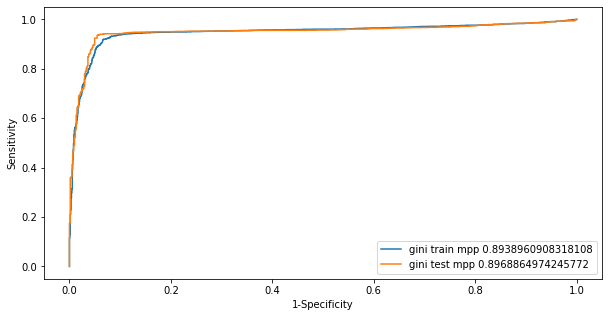

In [40]:
%%time


mpp = LogisticRegression(max_iter=800)
mpp, mpp_learn_scores = mpp_model_learn(mpp, lr_parameters_grid,
                                        X_train_mpp, y_train_mpp,
                                        validation_mpp_X, validation_mpp_y,
                                        cv_mpp, cv_gs,
                                        params_tuning=parameters_tuning)


mpp_train_mpp_probas, mpp_test_mpp_probas = apply_mpp_model(mpp, X_train_mpp, X_test_mpp)

mpp_train_mpp_gini, mpp_test_mpp_gini = count_sets_mpp_gini(mpp_train_mpp_probas, mpp_test_mpp_probas, y_train_mpp, y_test_mpp)

In [41]:
mpp_train_mpp_threshold, _ = calculate_threshold(mpp_train_mpp_probas, y_train_mpp, 0.02)

print("main model threshold:", mm_threshold)
print("mpp model threshold:", mpp_train_mpp_threshold)

KS stat max:


,interval,good,bad,bad_cum_prop,good_cum_prop,KS_stat
0,"[0.64, 0.66)",15,35,7.707129,92.53012,84.822991


main model threshold: 0.06
mpp model threshold: 0.66



accuracy main model train 0.748
predicted accuracy train 0.705
diff. 0.044

accuracy main model validation 0.746
predicted accuracy valdation 0.707
diff. 0.039

accuracy main model test 0.749
predicted accuracy test 0.703
diff. 0.046


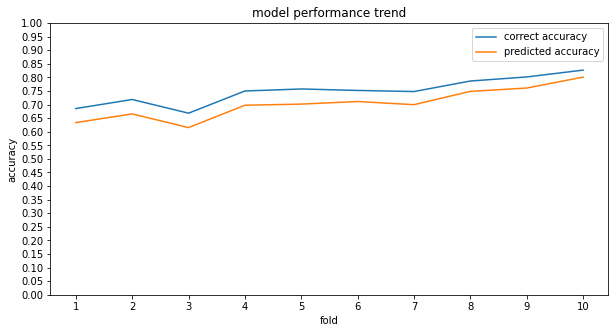

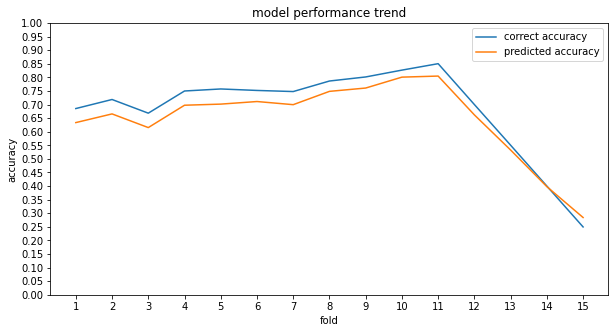

mean abs acc loss folds: 0.0021913809748498178
mean abs acc loss folds extended: 0.0017975396512419112
sum abs acc loss folds: 0.45955132562882417
sum abs acc loss folds extended: 0.5976465637240622


In [42]:
sets_test(mm, mpp, train_X, validation_X, test_X, train_y, validation_y, test_y, mm_threshold, mpp_train_mpp_threshold, inverse_target=inverse_target)

test_folds_trend_pairs = folds_test(folds, mm, mpp,
                                    mm_threshold, mpp_train_mpp_threshold,
                                    inverse_target=inverse_target)
test_folds_extended_trend_pairs = folds_test(folds_extended, mm, mpp,
                                             mm_threshold, mpp_train_mpp_threshold,
                                             inverse_target=inverse_target)

mpp_diff_scores = accuracy_loss_test(test_folds_trend_pairs, test_folds_extended_trend_pairs)

In [43]:
mpp_results_df["lr+lr"] = mpp_learn_scores + [mpp_train_mpp_gini, mpp_test_mpp_gini] + [mpp_diff_scores[0][0], mpp_diff_scores[1][0]] + [mpp_diff_scores[0][1], mpp_diff_scores[1][1]]

### Logistic regression(main) + Random forest(mpp)

rf Breiman samp size 3083

	MPP parameters tuning:

GS CV train gini mean: 0.972
GS CV validation gini mean: 0.914
	gs cv is 5

	Best parameters:
 {'max_depth': 8, 'max_features': 'sqrt', 'max_samples': None, 'min_samples_split': 2, 'n_estimators': 166, 'random_state': 4}

	MPP model learning:
CV train gini mean: 0.969
CV test gini mean: 0.914
	cv is 3

Fit parameters:
 {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 8, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 166, 'n_jobs': None, 'oob_score': False, 'random_state': 4, 'verbose': 0, 'warm_start': False}

gini mpp train: 0.969
gini mpp test: 0.915 

CPU times: total: 18.1 s
Wall time: 29min 10s


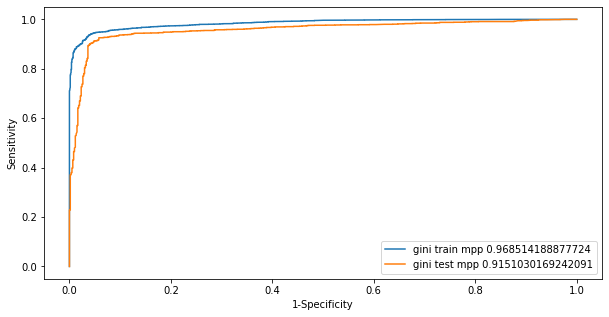

In [44]:
%%time


rf_parameters_grid_mpp = rf_parameters_grid
rf_parameters_grid_mpp.update(max_samples=[None, math.ceil(0.632*X_train_mpp.shape[0])])
print("rf Breiman samp size", math.ceil(0.632*X_train_mpp.shape[0]))

mpp = RandomForestClassifier(n_estimators=100, random_state=rand_state)
mpp, mpp_learn_scores = mpp_model_learn(mpp, rf_parameters_grid_mpp,
                                        X_train_mpp, y_train_mpp,
                                        validation_mpp_X, validation_mpp_y,
                                        cv_mpp, cv_gs,
                                        params_tuning=parameters_tuning)


mpp_train_mpp_probas, mpp_test_mpp_probas = apply_mpp_model(mpp, X_train_mpp, X_test_mpp)

mpp_train_mpp_gini, mpp_test_mpp_gini = count_sets_mpp_gini(mpp_train_mpp_probas, mpp_test_mpp_probas, y_train_mpp, y_test_mpp)

In [45]:
mpp_train_mpp_threshold, _ = calculate_threshold(mpp_train_mpp_probas, y_train_mpp, 0.02)

print("main model threshold:", mm_threshold)
print("mpp model threshold:", mpp_train_mpp_threshold)

KS stat max:


,interval,good,bad,bad_cum_prop,good_cum_prop,KS_stat
0,"[0.6, 0.62)",2,4,6.028076,95.823293,89.795217


main model threshold: 0.06
mpp model threshold: 0.62



accuracy main model train 0.748
predicted accuracy train 0.702
diff. 0.046

accuracy main model validation 0.746
predicted accuracy valdation 0.710
diff. 0.036

accuracy main model test 0.749
predicted accuracy test 0.702
diff. 0.048


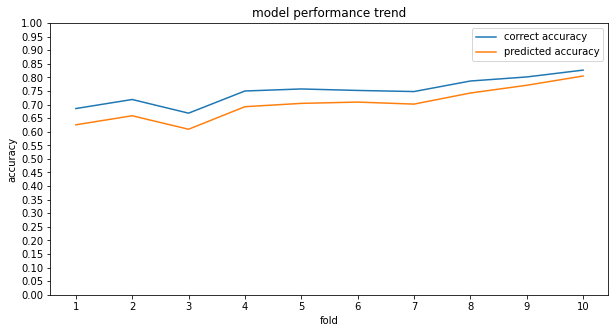

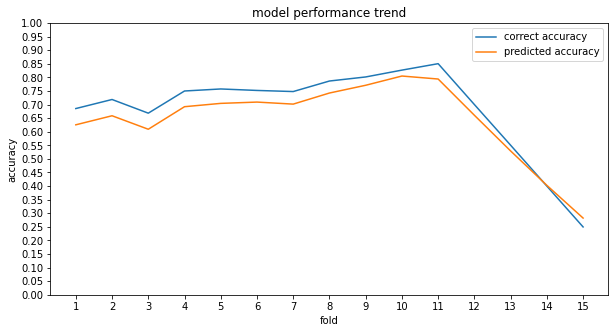

mean abs acc loss folds: 0.002413901945660522
mean abs acc loss folds extended: 0.002026810037292431
sum abs acc loss folds: 0.4751869476546572
sum abs acc loss folds extended: 0.6275679000356094


In [46]:
sets_test(mm, mpp, train_X, validation_X, test_X, train_y, validation_y, test_y, mm_threshold, mpp_train_mpp_threshold, inverse_target=inverse_target)

test_folds_trend_pairs = folds_test(folds, mm, mpp,
                                    mm_threshold, mpp_train_mpp_threshold,
                                    inverse_target=inverse_target)
test_folds_extended_trend_pairs = folds_test(folds_extended, mm, mpp,
                                             mm_threshold, mpp_train_mpp_threshold,
                                             inverse_target=inverse_target)

mpp_diff_scores = accuracy_loss_test(test_folds_trend_pairs, test_folds_extended_trend_pairs)

In [47]:
mpp_results_df["lr+rf"] = mpp_learn_scores + [mpp_train_mpp_gini, mpp_test_mpp_gini] + [mpp_diff_scores[0][0], mpp_diff_scores[1][0]] + [mpp_diff_scores[0][1], mpp_diff_scores[1][1]]

### Logistic regression(main) + CART(mpp)


	MPP parameters tuning:

GS CV train gini mean: 0.908
GS CV validation gini mean: 0.852
	gs cv is 5

	Best parameters:
 {'class_weight': None, 'criterion': 'gini', 'max_depth': 6, 'max_features': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 10, 'random_state': 4}

	MPP model learning:
CV train gini mean: 0.908
CV test gini mean: 0.860
	cv is 3

Fit parameters:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 6, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'random_state': 4, 'splitter': 'best'}

gini mpp train: 0.903
gini mpp test: 0.875 

CPU times: total: 266 ms
Wall time: 667 ms


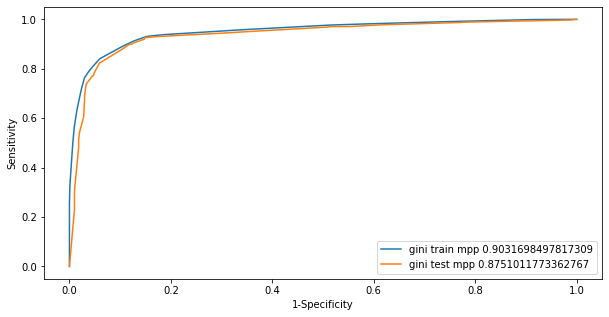

In [48]:
%%time


mpp = DecisionTreeClassifier(random_state=rand_state)
mpp, mpp_learn_scores = mpp_model_learn(mpp, dt_parameters_grid,
                                        X_train_mpp, y_train_mpp,
                                        validation_mpp_X, validation_mpp_y,
                                        cv_mpp, cv_gs,
                                        params_tuning=parameters_tuning)


mpp_train_mpp_probas, mpp_test_mpp_probas = apply_mpp_model(mpp, X_train_mpp, X_test_mpp)

mpp_train_mpp_gini, mpp_test_mpp_gini = count_sets_mpp_gini(mpp_train_mpp_probas, mpp_test_mpp_probas, y_train_mpp, y_test_mpp)

In [49]:
mpp_train_mpp_threshold, _ = calculate_threshold(mpp_train_mpp_probas, y_train_mpp, 0.02)

print("main model threshold:", mm_threshold)
print("mpp model threshold:", mpp_train_mpp_threshold)

KS stat max:


,interval,good,bad,bad_cum_prop,good_cum_prop,KS_stat
0,"[0.66, 0.68)",23,48,11.147903,86.746988,75.599085


main model threshold: 0.06
mpp model threshold: 0.68



accuracy main model train 0.748
predicted accuracy train 0.707
diff. 0.042

accuracy main model validation 0.746
predicted accuracy valdation 0.714
diff. 0.032

accuracy main model test 0.749
predicted accuracy test 0.712
diff. 0.037


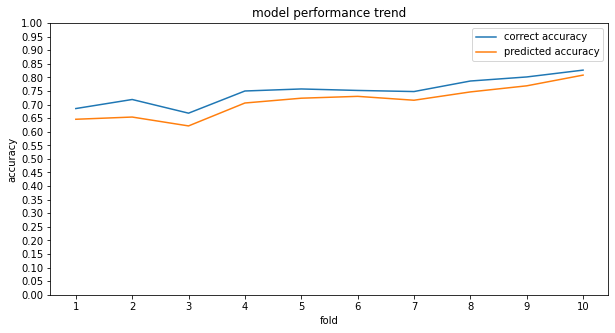

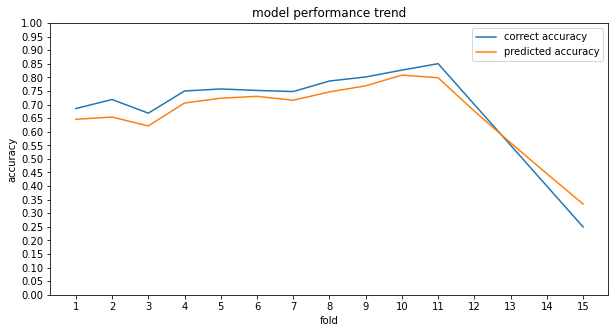

mean abs acc loss folds: 0.001553811024007773
mean abs acc loss folds extended: 0.0018721305140692599
sum abs acc loss folds: 0.37389530931339254
sum abs acc loss folds extended: 0.5888612957079504


In [50]:
sets_test(mm, mpp, train_X, validation_X, test_X, train_y, validation_y, test_y, mm_threshold, mpp_train_mpp_threshold, inverse_target=inverse_target)

test_folds_trend_pairs = folds_test(folds, mm, mpp,
                                    mm_threshold, mpp_train_mpp_threshold,
                                    inverse_target=inverse_target)
test_folds_extended_trend_pairs = folds_test(folds_extended, mm, mpp,
                                             mm_threshold, mpp_train_mpp_threshold,
                                             inverse_target=inverse_target)

mpp_diff_scores = accuracy_loss_test(test_folds_trend_pairs, test_folds_extended_trend_pairs)

In [51]:
mpp_results_df["lr+dt"] = mpp_learn_scores + [mpp_train_mpp_gini, mpp_test_mpp_gini] + [mpp_diff_scores[0][0], mpp_diff_scores[1][0]] + [mpp_diff_scores[0][1], mpp_diff_scores[1][1]]

### Logistic regression(main) + XG Boost(mpp)

C:\Program Files\Python310\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
16200 fits failed out of a total of 32400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
16200 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Program Files\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python310\lib\site-packages\xgboost\core.py", line 532, in inner_f
    return f(**kwargs)
  File "C:\Program Files\Python310\lib\site-packages\xgboost\sklearn.py", line 1400, in fit
    self._Booster = train(
  File "C:\Program Files\Python310\lib\site-packages\xgboost\co


	MPP parameters tuning:

GS CV train gini mean: 0.984
GS CV validation gini mean: 0.915
	gs cv is 5

	Best parameters:
 {'gamma': 1, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 1000, 'seed': 4, 'subsample': 1}

	MPP model learning:
CV train gini mean: 0.979
CV test gini mean: 0.913
	cv is 3

Fit parameters:
 {'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': 0.5, 'booster': 'gbtree', 'callbacks': None, 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'gamma': 1, 'gpu_id': -1, 'grow_policy': 'depthwise', 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.1, 'max_bin': 256, 'max_cat_to_onehot': 4, 'max_delta_step': 0, 'max_depth': 8, 'max_leaves': 0, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 1000, 'n_jobs': 0, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 4, 'reg_alpha': 0

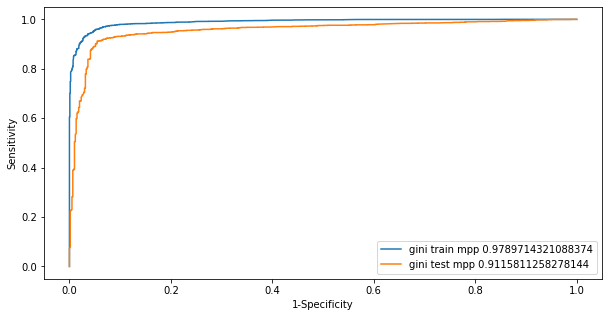

In [52]:
%%time


mpp = XGBClassifier(n_estimators=100, seed=rand_state)
mpp, mpp_learn_scores = mpp_model_learn(mpp, xgb_parameters_grid,
                                        X_train_mpp, y_train_mpp,
                                        validation_mpp_X, validation_mpp_y,
                                        cv_mpp, cv_gs,
                                        params_tuning=parameters_tuning)


mpp_train_mpp_probas, mpp_test_mpp_probas = apply_mpp_model(mpp, X_train_mpp, X_test_mpp)

mpp_train_mpp_gini, mpp_test_mpp_gini = count_sets_mpp_gini(mpp_train_mpp_probas, mpp_test_mpp_probas, y_train_mpp, y_test_mpp)

In [53]:
mpp_train_mpp_threshold, _ = calculate_threshold(mpp_train_mpp_probas, y_train_mpp, 0.02)

print("main model threshold:", mm_threshold)
print("mpp model threshold:", mpp_train_mpp_threshold)

KS stat max:


,interval,good,bad,bad_cum_prop,good_cum_prop,KS_stat
0,"[0.54, 0.56)",2,3,4.156345,94.859438,90.703093


main model threshold: 0.06
mpp model threshold: 0.56



accuracy main model train 0.748
predicted accuracy train 0.718
diff. 0.030

accuracy main model validation 0.746
predicted accuracy valdation 0.724
diff. 0.022

accuracy main model test 0.749
predicted accuracy test 0.718
diff. 0.031


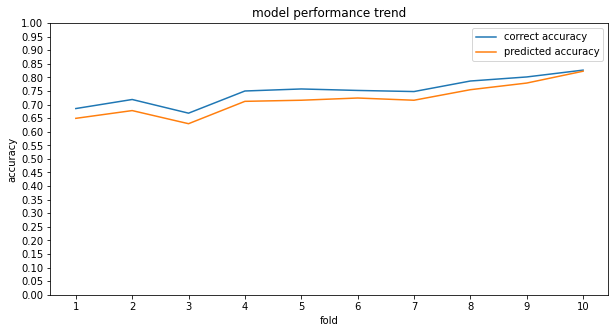

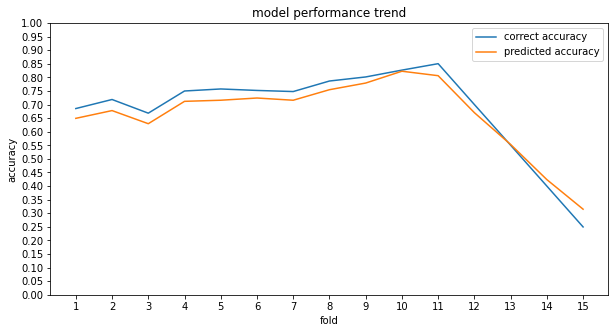

mean abs acc loss folds: 0.0010970769109190576
mean abs acc loss folds extended: 0.0012440722220078023
sum abs acc loss folds: 0.31339225016995276
sum abs acc loss folds extended: 0.4793786447277757


In [54]:
sets_test(mm, mpp, train_X, validation_X, test_X, train_y, validation_y, test_y, mm_threshold, mpp_train_mpp_threshold, inverse_target=inverse_target)

test_folds_trend_pairs = folds_test(folds, mm, mpp,
                                    mm_threshold, mpp_train_mpp_threshold,
                                    inverse_target=inverse_target)
test_folds_extended_trend_pairs = folds_test(folds_extended, mm, mpp,
                                             mm_threshold, mpp_train_mpp_threshold,
                                             inverse_target=inverse_target)

mpp_diff_scores = accuracy_loss_test(test_folds_trend_pairs, test_folds_extended_trend_pairs)

## Main random forest

### Set up

In [56]:
mm = rf
mm_train_probas = rf_train_probas
mm_validation_probas = rf_validation_probas
mm_test_probas = rf_test_probas
mm_threshold = rf_train_threshold

In [57]:
folds = get_folds(test, nfolds, stratified=True)
avg_fold_len = round(len(test)/nfolds)


mm_test_mpp_targets = count_mpp_target_accuracy(mm_test_probas, test_y, mm_threshold)
mm_test_correct = test[mm_test_mpp_targets["mpp_target"] == 1]
mm_test_errors = test[mm_test_mpp_targets["mpp_target"] == 0]

folds_emulated = [
    pd.concat([mm_test_errors.sample(int(0.15*avg_fold_len)), mm_test_correct.sample(int(0.85*avg_fold_len))], axis=0),
    pd.concat([mm_test_errors.sample(int(0.30*avg_fold_len)), mm_test_correct.sample(int(0.70*avg_fold_len))], axis=0),
    pd.concat([mm_test_errors.sample(int(0.45*avg_fold_len)), mm_test_correct.sample(int(0.55*avg_fold_len))], axis=0),
    pd.concat([mm_test_errors.sample(int(0.60*avg_fold_len)), mm_test_correct.sample(int(0.40*avg_fold_len))], axis=0),
    pd.concat([mm_test_errors.sample(int(0.75*avg_fold_len)), mm_test_correct.sample(int(0.25*avg_fold_len))], axis=0)
]
folds_extended = folds + folds_emulated

In [58]:
validation_mpp_targets = count_mpp_target_accuracy(mm_validation_probas, validation_y, mm_threshold,
                                                   inverse=inverse_target)


validation_mpp = pd.concat([validation_X, validation_mpp_targets], axis=1)
validation_mpp_X = validation_mpp.drop(columns=[target_mpp])
validation_mpp_y = validation_mpp[target_mpp]

X_train_mpp, X_test_mpp, y_train_mpp, y_test_mpp = train_test_split(validation_mpp_X, validation_mpp_y, test_size=mpp_test_size, random_state=rand_state_mpp)

### Random forest(main) + Logistic regression(mpp)


	MPP parameters tuning:

GS CV train gini mean: 0.870
GS CV validation gini mean: 0.869
	gs cv is 5

	Best parameters:
 {'C': 159.98587196060572, 'max_iter': 100, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'liblinear'}

	MPP model learning:
CV train gini mean: 0.865
CV test gini mean: 0.863
	cv is 3

Fit parameters:
 {'C': 159.98587196060572, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

gini mpp train: 0.869
gini mpp test: 0.856 

CPU times: total: 3.78 s
Wall time: 1min 17s


C:\Program Files\Python310\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
4250 fits failed out of a total of 17000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4250 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Program Files\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python310\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python310\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise V

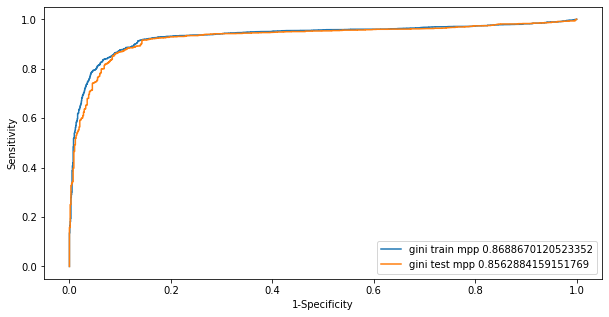

In [59]:
%%time


mpp = LogisticRegression(max_iter=800)
mpp, mpp_learn_scores = mpp_model_learn(mpp, lr_parameters_grid,
                                        X_train_mpp, y_train_mpp,
                                        validation_mpp_X, validation_mpp_y,
                                        cv_mpp, cv_gs,
                                        params_tuning=parameters_tuning)


mpp_train_mpp_probas, mpp_test_mpp_probas = apply_mpp_model(mpp, X_train_mpp, X_test_mpp)

mpp_train_mpp_gini, mpp_test_mpp_gini = count_sets_mpp_gini(mpp_train_mpp_probas, mpp_test_mpp_probas, y_train_mpp, y_test_mpp)

In [60]:
mpp_train_mpp_threshold, _ = calculate_threshold(mpp_train_mpp_probas, y_train_mpp, 0.02)

print("main model threshold:", mm_threshold)
print("mpp model threshold:", mpp_train_mpp_threshold)

KS stat max:


,interval,good,bad,bad_cum_prop,good_cum_prop,KS_stat
0,"[0.66, 0.68)",21,45,13.460444,90.909091,77.448647


main model threshold: 0.06
mpp model threshold: 0.68



accuracy main model train 0.726
predicted accuracy train 0.638
diff. 0.087

accuracy main model validation 0.718
predicted accuracy valdation 0.649
diff. 0.070

accuracy main model test 0.716
predicted accuracy test 0.635
diff. 0.081


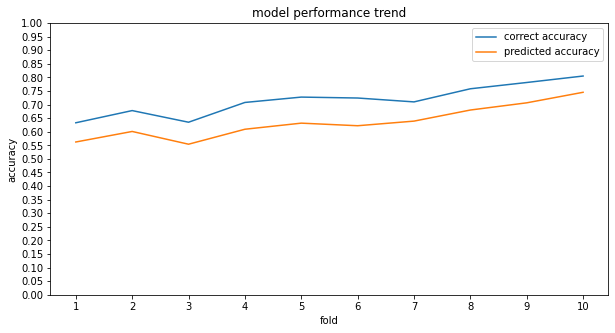

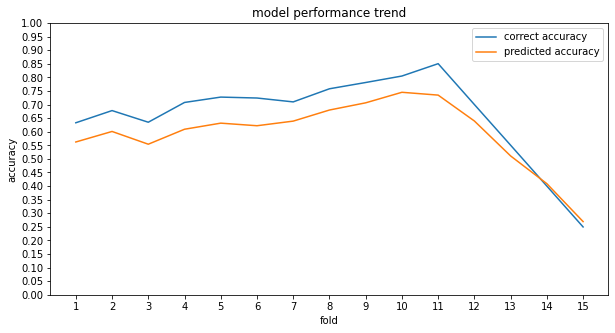

mean abs acc loss folds: 0.006702756810689878
mean abs acc loss folds extended: 0.005739425607299352
sum abs acc loss folds: 0.8082936777702243
sum abs acc loss folds extended: 1.0525113648450544


In [61]:
sets_test(mm, mpp, train_X, validation_X, test_X, train_y, validation_y, test_y, mm_threshold, mpp_train_mpp_threshold, inverse_target=inverse_target)

test_folds_trend_pairs = folds_test(folds, mm, mpp,
                                    mm_threshold, mpp_train_mpp_threshold,
                                    inverse_target=inverse_target)
test_folds_extended_trend_pairs = folds_test(folds_extended, mm, mpp,
                                             mm_threshold, mpp_train_mpp_threshold,
                                             inverse_target=inverse_target)

mpp_diff_scores = accuracy_loss_test(test_folds_trend_pairs, test_folds_extended_trend_pairs)

In [62]:
mpp_results_df["rf+lr"] = mpp_learn_scores + [mpp_train_mpp_gini, mpp_test_mpp_gini] + [mpp_diff_scores[0][0], mpp_diff_scores[1][0]] + [mpp_diff_scores[0][1], mpp_diff_scores[1][1]]

### Random forest(main) + Random forest(mpp)

rf Breiman samp size 3083

	MPP parameters tuning:

GS CV train gini mean: 0.974
GS CV validation gini mean: 0.915
	gs cv is 5

	Best parameters:
 {'max_depth': 8, 'max_features': 'sqrt', 'max_samples': 3083, 'min_samples_split': 2, 'n_estimators': 166, 'random_state': 4}

	MPP model learning:
CV train gini mean: 0.971
CV test gini mean: 0.917
	cv is 3

Fit parameters:
 {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 8, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': 3083, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 166, 'n_jobs': None, 'oob_score': False, 'random_state': 4, 'verbose': 0, 'warm_start': False}

gini mpp train: 0.969
gini mpp test: 0.917 

CPU times: total: 17.9 s
Wall time: 29min 20s


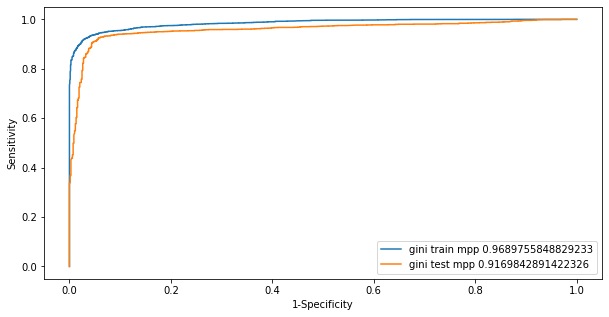

In [63]:
%%time


rf_parameters_grid_mpp = rf_parameters_grid
rf_parameters_grid_mpp.update(max_samples=[None, math.ceil(0.632*X_train_mpp.shape[0])])
print("rf Breiman samp size", math.ceil(0.632*X_train_mpp.shape[0]))

mpp = RandomForestClassifier(n_estimators=100, random_state=rand_state)
mpp, mpp_learn_scores = mpp_model_learn(mpp, rf_parameters_grid_mpp,
                                        X_train_mpp, y_train_mpp,
                                        validation_mpp_X, validation_mpp_y,
                                        cv_mpp, cv_gs,
                                        params_tuning=parameters_tuning)


mpp_train_mpp_probas, mpp_test_mpp_probas = apply_mpp_model(mpp, X_train_mpp, X_test_mpp)

mpp_train_mpp_gini, mpp_test_mpp_gini = count_sets_mpp_gini(mpp_train_mpp_probas, mpp_test_mpp_probas, y_train_mpp, y_test_mpp)

In [64]:
mpp_train_mpp_threshold, _ = calculate_threshold(mpp_train_mpp_probas, y_train_mpp, 0.02)

print("main model threshold:", mm_threshold)
print("mpp model threshold:", mpp_train_mpp_threshold)

KS stat max:


,interval,good,bad,bad_cum_prop,good_cum_prop,KS_stat
0,"[0.68, 0.7)",7,14,7.854297,96.994135,89.139838


main model threshold: 0.06
mpp model threshold: 0.7



accuracy main model train 0.726
predicted accuracy train 0.658
diff. 0.067

accuracy main model validation 0.718
predicted accuracy valdation 0.666
diff. 0.052

accuracy main model test 0.716
predicted accuracy test 0.656
diff. 0.060


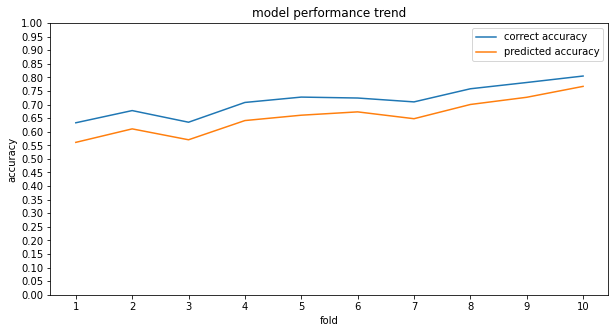

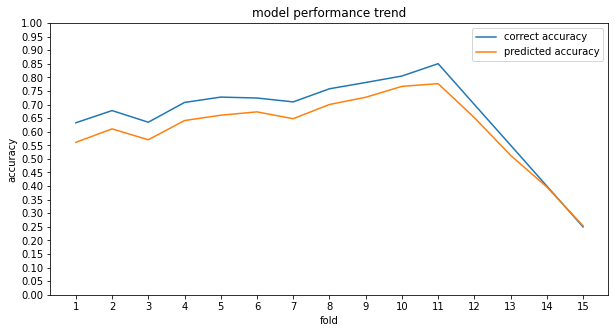

mean abs acc loss folds: 0.003694217828389425
mean abs acc loss folds extended: 0.0030733908110406796
sum abs acc loss folds: 0.6002719238613189
sum abs acc loss folds extended: 0.7669385905279856


In [65]:
sets_test(mm, mpp, train_X, validation_X, test_X, train_y, validation_y, test_y, mm_threshold, mpp_train_mpp_threshold, inverse_target=inverse_target)

test_folds_trend_pairs = folds_test(folds, mm, mpp,
                                    mm_threshold, mpp_train_mpp_threshold,
                                    inverse_target=inverse_target)
test_folds_extended_trend_pairs = folds_test(folds_extended, mm, mpp,
                                             mm_threshold, mpp_train_mpp_threshold,
                                             inverse_target=inverse_target)

mpp_diff_scores = accuracy_loss_test(test_folds_trend_pairs, test_folds_extended_trend_pairs)

In [66]:
mpp_results_df["rf+rf"] = mpp_learn_scores + [mpp_train_mpp_gini, mpp_test_mpp_gini] + [mpp_diff_scores[0][0], mpp_diff_scores[1][0]] + [mpp_diff_scores[0][1], mpp_diff_scores[1][1]]

### Random forest(main) + CART(mpp)


	MPP parameters tuning:

GS CV train gini mean: 0.939
GS CV validation gini mean: 0.865
	gs cv is 5

	Best parameters:
 {'class_weight': None, 'criterion': 'gini', 'max_depth': 7, 'max_features': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 10, 'random_state': 4}

	MPP model learning:
CV train gini mean: 0.944
CV test gini mean: 0.863
	cv is 3

Fit parameters:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 7, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'random_state': 4, 'splitter': 'best'}

gini mpp train: 0.935
gini mpp test: 0.866 

CPU times: total: 281 ms
Wall time: 658 ms


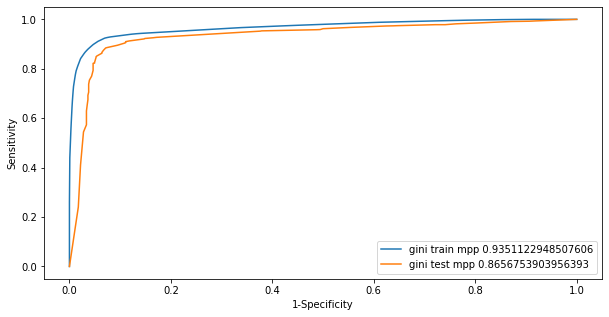

In [67]:
%%time


mpp = DecisionTreeClassifier(random_state=rand_state)
mpp, mpp_learn_scores = mpp_model_learn(mpp, dt_parameters_grid,
                                        X_train_mpp, y_train_mpp,
                                        validation_mpp_X, validation_mpp_y,
                                        cv_mpp, cv_gs,
                                        params_tuning=parameters_tuning)


mpp_train_mpp_probas, mpp_test_mpp_probas = apply_mpp_model(mpp, X_train_mpp, X_test_mpp)

mpp_train_mpp_gini, mpp_test_mpp_gini = count_sets_mpp_gini(mpp_train_mpp_probas, mpp_test_mpp_probas, y_train_mpp, y_test_mpp)

In [68]:
mpp_train_mpp_threshold, _ = calculate_threshold(mpp_train_mpp_probas, y_train_mpp, 0.02)

print("main model threshold:", mm_threshold)
print("mpp model threshold:", mpp_train_mpp_threshold)

KS stat max:


,interval,good,bad,bad_cum_prop,good_cum_prop,KS_stat
0,"[0.64, 0.66)",0,0,10.253456,93.035191,82.781734


main model threshold: 0.06
mpp model threshold: 0.66



accuracy main model train 0.726
predicted accuracy train 0.681
diff. 0.044

accuracy main model validation 0.718
predicted accuracy valdation 0.683
diff. 0.035

accuracy main model test 0.716
predicted accuracy test 0.679
diff. 0.036


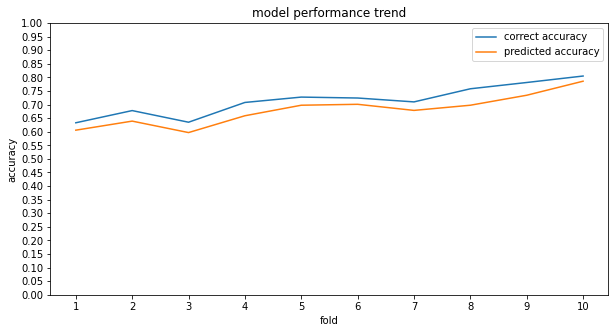

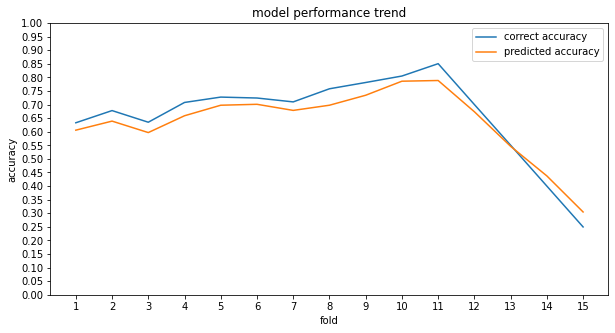

mean abs acc loss folds: 0.001471596110804814
mean abs acc loss folds extended: 0.0015803205565082822
sum abs acc loss folds: 0.363698164513936
sum abs acc loss folds extended: 0.5487321781193781


In [69]:
sets_test(mm, mpp, train_X, validation_X, test_X, train_y, validation_y, test_y, mm_threshold, mpp_train_mpp_threshold, inverse_target=inverse_target)

test_folds_trend_pairs = folds_test(folds, mm, mpp,
                                    mm_threshold, mpp_train_mpp_threshold,
                                    inverse_target=inverse_target)
test_folds_extended_trend_pairs = folds_test(folds_extended, mm, mpp,
                                             mm_threshold, mpp_train_mpp_threshold,
                                             inverse_target=inverse_target)

mpp_diff_scores = accuracy_loss_test(test_folds_trend_pairs, test_folds_extended_trend_pairs)

In [70]:
mpp_results_df["rf+dt"] = mpp_learn_scores + [mpp_train_mpp_gini, mpp_test_mpp_gini] + [mpp_diff_scores[0][0], mpp_diff_scores[1][0]] + [mpp_diff_scores[0][1], mpp_diff_scores[1][1]]

### Random forest(main) +  XG Boost(mpp)

C:\Program Files\Python310\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
16200 fits failed out of a total of 32400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
16200 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Program Files\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python310\lib\site-packages\xgboost\core.py", line 532, in inner_f
    return f(**kwargs)
  File "C:\Program Files\Python310\lib\site-packages\xgboost\sklearn.py", line 1400, in fit
    self._Booster = train(
  File "C:\Program Files\Python310\lib\site-packages\xgboost\co


	MPP parameters tuning:

GS CV train gini mean: 0.982
GS CV validation gini mean: 0.916
	gs cv is 5

	Best parameters:
 {'gamma': 0.3, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 100, 'seed': 4, 'subsample': 1}

	MPP model learning:
CV train gini mean: 0.981
CV test gini mean: 0.916
	cv is 3

Fit parameters:
 {'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': 0.5, 'booster': 'gbtree', 'callbacks': None, 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'gamma': 0.3, 'gpu_id': -1, 'grow_policy': 'depthwise', 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.05, 'max_bin': 256, 'max_cat_to_onehot': 4, 'max_delta_step': 0, 'max_depth': 8, 'max_leaves': 0, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 100, 'n_jobs': 0, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 4, 'reg_alpha

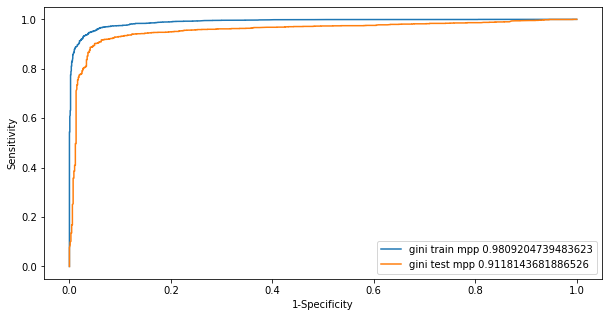

In [71]:
%%time


mpp = XGBClassifier(n_estimators=100, seed=rand_state)
mpp, mpp_learn_scores = mpp_model_learn(mpp, xgb_parameters_grid,
                                        X_train_mpp, y_train_mpp,
                                        validation_mpp_X, validation_mpp_y,
                                        cv_mpp, cv_gs,
                                        params_tuning=parameters_tuning)


mpp_train_mpp_probas, mpp_test_mpp_probas = apply_mpp_model(mpp, X_train_mpp, X_test_mpp)

mpp_train_mpp_gini, mpp_test_mpp_gini = count_sets_mpp_gini(mpp_train_mpp_probas, mpp_test_mpp_probas, y_train_mpp, y_test_mpp)

In [72]:
mpp_train_mpp_threshold, _ = calculate_threshold(mpp_train_mpp_probas, y_train_mpp, 0.02)

print("main model threshold:", mm_threshold)
print("mpp model threshold:", mpp_train_mpp_threshold)

KS stat max:


,interval,good,bad,bad_cum_prop,good_cum_prop,KS_stat
0,"[0.6, 0.62)",3,7,5.492316,96.187683,90.695367


main model threshold: 0.06
mpp model threshold: 0.62



accuracy main model train 0.726
predicted accuracy train 0.684
diff. 0.042

accuracy main model validation 0.718
predicted accuracy valdation 0.688
diff. 0.031

accuracy main model test 0.716
predicted accuracy test 0.681
diff. 0.035


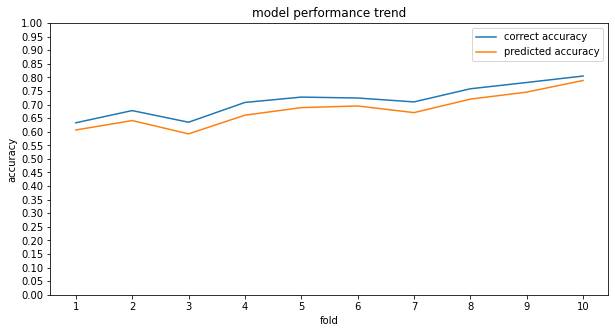

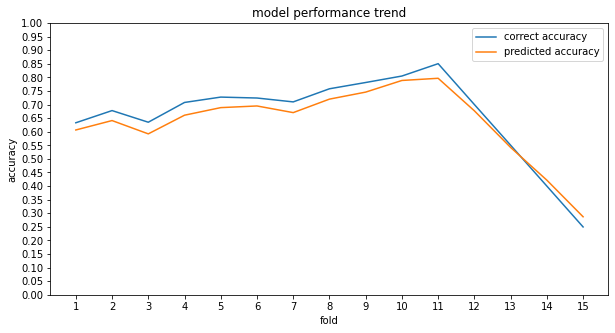

mean abs acc loss folds: 0.0012960748964457186
mean abs acc loss folds extended: 0.0012216169940702335
sum abs acc loss folds: 0.3501019714479946
sum abs acc loss folds extended: 0.49431965852282445


In [73]:
sets_test(mm, mpp, train_X, validation_X, test_X, train_y, validation_y, test_y, mm_threshold, mpp_train_mpp_threshold, inverse_target=inverse_target)

test_folds_trend_pairs = folds_test(folds, mm, mpp,
                                    mm_threshold, mpp_train_mpp_threshold,
                                    inverse_target=inverse_target)
test_folds_extended_trend_pairs = folds_test(folds_extended, mm, mpp,
                                             mm_threshold, mpp_train_mpp_threshold,
                                             inverse_target=inverse_target)

mpp_diff_scores = accuracy_loss_test(test_folds_trend_pairs, test_folds_extended_trend_pairs)

In [74]:
mpp_results_df["rf+xgb"] = mpp_learn_scores + [mpp_train_mpp_gini, mpp_test_mpp_gini] + [mpp_diff_scores[0][0], mpp_diff_scores[1][0]] + [mpp_diff_scores[0][1], mpp_diff_scores[1][1]]

## Main CART

### Set up

In [75]:
mm = dt
mm_train_probas = dt_train_probas
mm_validation_probas = dt_validation_probas
mm_test_probas = dt_test_probas
mm_threshold = dt_train_threshold

In [76]:
folds = get_folds(test, nfolds, stratified=True)
avg_fold_len = round(len(test)/nfolds)


mm_test_mpp_targets = count_mpp_target_accuracy(mm_test_probas, test_y, mm_threshold)
mm_test_correct = test[mm_test_mpp_targets["mpp_target"] == 1]
mm_test_errors = test[mm_test_mpp_targets["mpp_target"] == 0]

folds_emulated = [
    pd.concat([mm_test_errors.sample(int(0.15*avg_fold_len)), mm_test_correct.sample(int(0.85*avg_fold_len))], axis=0),
    pd.concat([mm_test_errors.sample(int(0.30*avg_fold_len)), mm_test_correct.sample(int(0.70*avg_fold_len))], axis=0),
    pd.concat([mm_test_errors.sample(int(0.45*avg_fold_len)), mm_test_correct.sample(int(0.55*avg_fold_len))], axis=0),
    pd.concat([mm_test_errors.sample(int(0.60*avg_fold_len)), mm_test_correct.sample(int(0.40*avg_fold_len))], axis=0),
    pd.concat([mm_test_errors.sample(int(0.75*avg_fold_len)), mm_test_correct.sample(int(0.25*avg_fold_len))], axis=0)
]
folds_extended = folds + folds_emulated

In [77]:
validation_mpp_targets = count_mpp_target_accuracy(mm_validation_probas, validation_y, mm_threshold,
                                                   inverse=inverse_target)


validation_mpp = pd.concat([validation_X, validation_mpp_targets], axis=1)
validation_mpp_X = validation_mpp.drop(columns=[target_mpp])
validation_mpp_y = validation_mpp[target_mpp]

X_train_mpp, X_test_mpp, y_train_mpp, y_test_mpp = train_test_split(validation_mpp_X, validation_mpp_y, test_size=mpp_test_size, random_state=rand_state_mpp)

### CART(main) + Logistic regression(mpp)

C:\Program Files\Python310\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
4250 fits failed out of a total of 17000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4250 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Program Files\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python310\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python310\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise V


	MPP parameters tuning:

GS CV train gini mean: 0.825
GS CV validation gini mean: 0.824
	gs cv is 5

	Best parameters:
 {'C': 494.1713361323828, 'max_iter': 3700, 'multi_class': 'ovr', 'penalty': 'l1', 'solver': 'liblinear'}

	MPP model learning:
CV train gini mean: 0.832
CV test gini mean: 0.831
	cv is 3

Fit parameters:
 {'C': 494.1713361323828, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 3700, 'multi_class': 'ovr', 'n_jobs': None, 'penalty': 'l1', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

gini mpp train: 0.825
gini mpp test: 0.841 

CPU times: total: 4.12 s
Wall time: 1min 11s


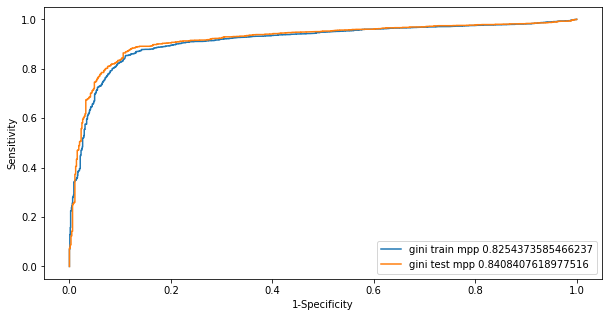

In [78]:
%%time


mpp = LogisticRegression(max_iter=800)
mpp, mpp_learn_scores = mpp_model_learn(mpp, lr_parameters_grid,
                                        X_train_mpp, y_train_mpp,
                                        validation_mpp_X, validation_mpp_y,
                                        cv_mpp, cv_gs,
                                        params_tuning=parameters_tuning)


mpp_train_mpp_probas, mpp_test_mpp_probas = apply_mpp_model(mpp, X_train_mpp, X_test_mpp)

mpp_train_mpp_gini, mpp_test_mpp_gini = count_sets_mpp_gini(mpp_train_mpp_probas, mpp_test_mpp_probas, y_train_mpp, y_test_mpp)

In [79]:
mpp_train_mpp_threshold, _ = calculate_threshold(mpp_train_mpp_probas, y_train_mpp, 0.02)

print("main model threshold:", mm_threshold)
print("mpp model threshold:", mpp_train_mpp_threshold)

KS stat max:


,interval,good,bad,bad_cum_prop,good_cum_prop,KS_stat
0,"[0.7, 0.72)",20,47,14.626039,88.485804,73.859766


main model threshold: 0.06
mpp model threshold: 0.72



accuracy main model train 0.736
predicted accuracy train 0.658
diff. 0.078

accuracy main model validation 0.736
predicted accuracy valdation 0.661
diff. 0.075

accuracy main model test 0.738
predicted accuracy test 0.656
diff. 0.082


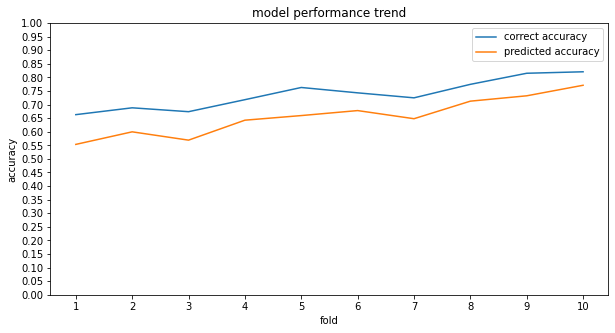

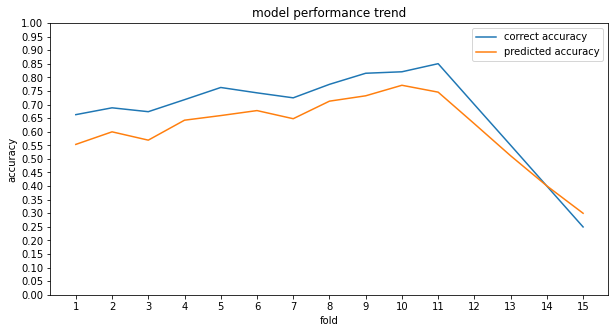

mean abs acc loss folds: 0.007044926129045524
mean abs acc loss folds extended: 0.006031184806409203
sum abs acc loss folds: 0.8178110129163834
sum abs acc loss folds extended: 1.0831171353653628


In [80]:
sets_test(mm, mpp, train_X, validation_X, test_X, train_y, validation_y, test_y, mm_threshold, mpp_train_mpp_threshold, inverse_target=inverse_target)

test_folds_trend_pairs = folds_test(folds, mm, mpp,
                                    mm_threshold, mpp_train_mpp_threshold,
                                    inverse_target=inverse_target)
test_folds_extended_trend_pairs = folds_test(folds_extended, mm, mpp,
                                             mm_threshold, mpp_train_mpp_threshold,
                                             inverse_target=inverse_target)

mpp_diff_scores = accuracy_loss_test(test_folds_trend_pairs, test_folds_extended_trend_pairs)

In [81]:
mpp_results_df["dt+lr"] = mpp_learn_scores + [mpp_train_mpp_gini, mpp_test_mpp_gini] + [mpp_diff_scores[0][0], mpp_diff_scores[1][0]] + [mpp_diff_scores[0][1], mpp_diff_scores[1][1]]

### CART(main) + Random forest(mpp)

rf Breiman samp size 3083

	MPP parameters tuning:

GS CV train gini mean: 0.973
GS CV validation gini mean: 0.917
	gs cv is 5

	Best parameters:
 {'max_depth': None, 'max_features': None, 'max_samples': 3083, 'min_samples_split': 50, 'n_estimators': 100, 'random_state': 4}

	MPP model learning:
CV train gini mean: 0.972
CV test gini mean: 0.921
	cv is 3

Fit parameters:
 {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'max_samples': 3083, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 50, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 4, 'verbose': 0, 'warm_start': False}

gini mpp train: 0.972
gini mpp test: 0.940 

CPU times: total: 18 s
Wall time: 29min 18s


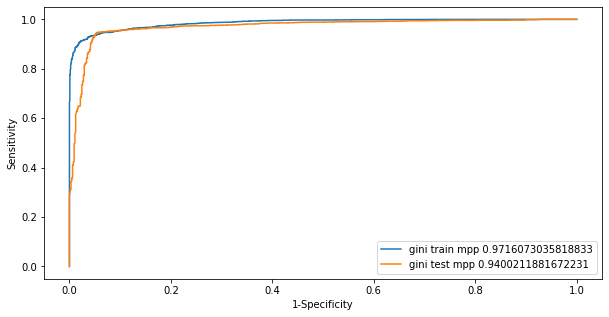

In [82]:
%%time


rf_parameters_grid_mpp = rf_parameters_grid
rf_parameters_grid_mpp.update(max_samples=[None, math.ceil(0.632*X_train_mpp.shape[0])])
print("rf Breiman samp size", math.ceil(0.632*X_train_mpp.shape[0]))

mpp = RandomForestClassifier(n_estimators=100, random_state=rand_state)
mpp, mpp_learn_scores = mpp_model_learn(mpp, rf_parameters_grid,
                                        X_train_mpp, y_train_mpp,
                                        validation_mpp_X, validation_mpp_y,
                                        cv_mpp, cv_gs,
                                        params_tuning=parameters_tuning)


mpp_train_mpp_probas, mpp_test_mpp_probas = apply_mpp_model(mpp, X_train_mpp, X_test_mpp)

mpp_train_mpp_gini, mpp_test_mpp_gini = count_sets_mpp_gini(mpp_train_mpp_probas, mpp_test_mpp_probas, y_train_mpp, y_test_mpp)

In [83]:
mpp_train_mpp_threshold, _ = calculate_threshold(mpp_train_mpp_probas, y_train_mpp, 0.02)

print("main model threshold:", mm_threshold)
print("mpp model threshold:", mpp_train_mpp_threshold)

KS stat max:


,interval,good,bad,bad_cum_prop,good_cum_prop,KS_stat
0,"[0.8, 0.82)",9,8,8.077437,95.583596,87.50616


main model threshold: 0.06
mpp model threshold: 0.82



accuracy main model train 0.736
predicted accuracy train 0.695
diff. 0.042

accuracy main model validation 0.736
predicted accuracy valdation 0.698
diff. 0.038

accuracy main model test 0.738
predicted accuracy test 0.698
diff. 0.040


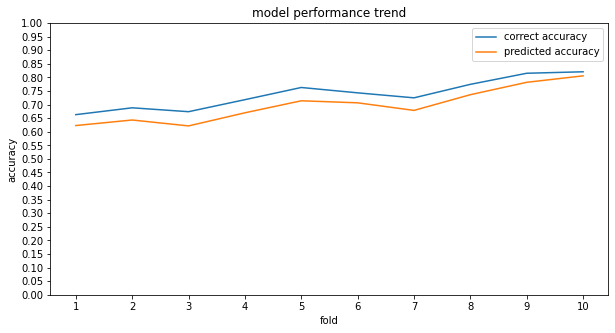

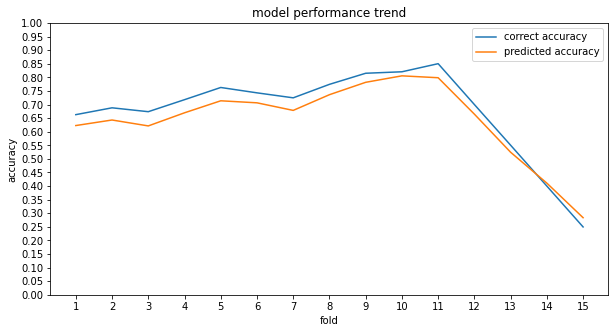

mean abs acc loss folds: 0.0017354325017411147
mean abs acc loss folds extended: 0.0015481500279242826
sum abs acc loss folds: 0.40380693405846335
sum abs acc loss folds extended: 0.5616300633101641


In [84]:
sets_test(mm, mpp, train_X, validation_X, test_X, train_y, validation_y, test_y, mm_threshold, mpp_train_mpp_threshold, inverse_target=inverse_target)

test_folds_trend_pairs = folds_test(folds, mm, mpp,
                                    mm_threshold, mpp_train_mpp_threshold,
                                    inverse_target=inverse_target)
test_folds_extended_trend_pairs = folds_test(folds_extended, mm, mpp,
                                             mm_threshold, mpp_train_mpp_threshold,
                                             inverse_target=inverse_target)

mpp_diff_scores = accuracy_loss_test(test_folds_trend_pairs, test_folds_extended_trend_pairs)

In [85]:
mpp_results_df["dt+rf"] = mpp_learn_scores + [mpp_train_mpp_gini, mpp_test_mpp_gini] + [mpp_diff_scores[0][0], mpp_diff_scores[1][0]] + [mpp_diff_scores[0][1], mpp_diff_scores[1][1]]

### CART(main) + CART(mpp)


	MPP parameters tuning:

GS CV train gini mean: 0.931
GS CV validation gini mean: 0.898
	gs cv is 5

	Best parameters:
 {'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 2, 'random_state': 4}

	MPP model learning:
CV train gini mean: 0.932
CV test gini mean: 0.897
	cv is 3

Fit parameters:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 4, 'splitter': 'best'}

gini mpp train: 0.926
gini mpp test: 0.921 

CPU times: total: 297 ms
Wall time: 702 ms


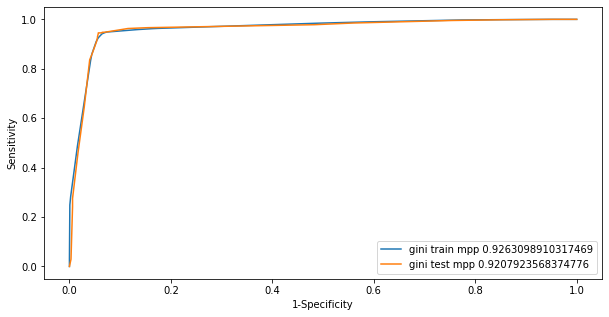

In [86]:
%%time


mpp = DecisionTreeClassifier(random_state=rand_state)
mpp, mpp_learn_scores = mpp_model_learn(mpp, dt_parameters_grid,
                                        X_train_mpp, y_train_mpp,
                                        validation_mpp_X, validation_mpp_y,
                                        cv_mpp, cv_gs,
                                        params_tuning=parameters_tuning)


mpp_train_mpp_probas, mpp_test_mpp_probas = apply_mpp_model(mpp, X_train_mpp, X_test_mpp)

mpp_train_mpp_gini, mpp_test_mpp_gini = count_sets_mpp_gini(mpp_train_mpp_probas, mpp_test_mpp_probas, y_train_mpp, y_test_mpp)

In [87]:
mpp_train_mpp_threshold, _ = calculate_threshold(mpp_train_mpp_probas, y_train_mpp, 0.02)

print("main model threshold:", mm_threshold)
print("mpp model threshold:", mpp_train_mpp_threshold)

KS stat max:


,interval,good,bad,bad_cum_prop,good_cum_prop,KS_stat
0,"[0.74, 0.76)",0,0,5.915976,93.454259,87.538283


main model threshold: 0.06
mpp model threshold: 0.76



accuracy main model train 0.736
predicted accuracy train 0.709
diff. 0.027

accuracy main model validation 0.736
predicted accuracy valdation 0.712
diff. 0.024

accuracy main model test 0.738
predicted accuracy test 0.712
diff. 0.026


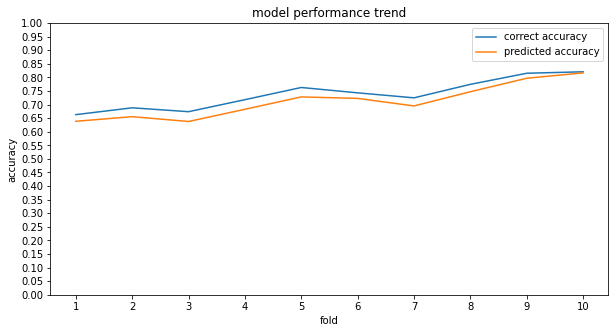

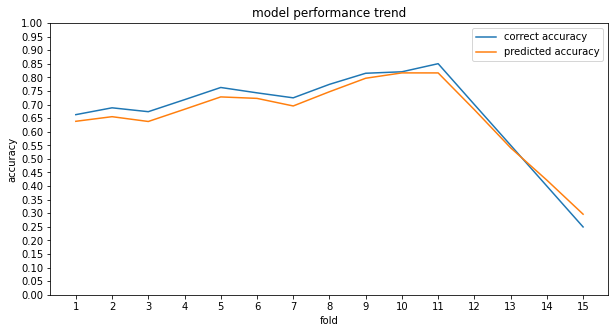

mean abs acc loss folds: 0.0007817117801169305
mean abs acc loss folds extended: 0.0008069788778301242
sum abs acc loss folds: 0.26308633582596863
sum abs acc loss folds extended: 0.3943788528327712


In [88]:
sets_test(mm, mpp, train_X, validation_X, test_X, train_y, validation_y, test_y, mm_threshold, mpp_train_mpp_threshold, inverse_target=inverse_target)

test_folds_trend_pairs = folds_test(folds, mm, mpp,
                                    mm_threshold, mpp_train_mpp_threshold,
                                    inverse_target=inverse_target)
test_folds_extended_trend_pairs = folds_test(folds_extended, mm, mpp,
                                             mm_threshold, mpp_train_mpp_threshold,
                                             inverse_target=inverse_target)

mpp_diff_scores = accuracy_loss_test(test_folds_trend_pairs, test_folds_extended_trend_pairs)

In [89]:
mpp_results_df["dt+dt"] = mpp_learn_scores + [mpp_train_mpp_gini, mpp_test_mpp_gini] + [mpp_diff_scores[0][0], mpp_diff_scores[1][0]] + [mpp_diff_scores[0][1], mpp_diff_scores[1][1]]

### CART(main) + XG Boost(mpp)

C:\Program Files\Python310\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
16200 fits failed out of a total of 32400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
16200 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Program Files\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python310\lib\site-packages\xgboost\core.py", line 532, in inner_f
    return f(**kwargs)
  File "C:\Program Files\Python310\lib\site-packages\xgboost\sklearn.py", line 1400, in fit
    self._Booster = train(
  File "C:\Program Files\Python310\lib\site-packages\xgboost\co


	MPP parameters tuning:

GS CV train gini mean: 0.976
GS CV validation gini mean: 0.922
	gs cv is 5

	Best parameters:
 {'gamma': 1, 'learning_rate': 0.02, 'max_depth': 6, 'n_estimators': 359, 'seed': 4, 'subsample': 1}

	MPP model learning:
CV train gini mean: 0.977
CV test gini mean: 0.925
	cv is 3

Fit parameters:
 {'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': 0.5, 'booster': 'gbtree', 'callbacks': None, 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'gamma': 1, 'gpu_id': -1, 'grow_policy': 'depthwise', 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.02, 'max_bin': 256, 'max_cat_to_onehot': 4, 'max_delta_step': 0, 'max_depth': 6, 'max_leaves': 0, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 359, 'n_jobs': 0, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 4, 'reg_alpha': 0

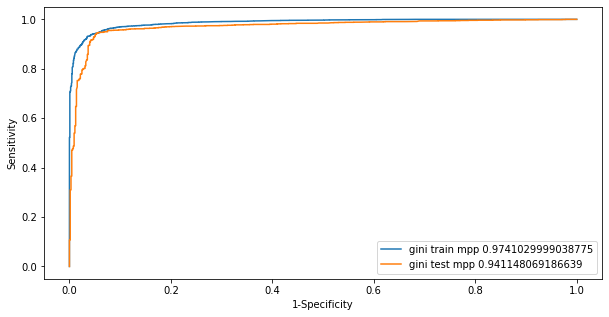

In [90]:
%%time


mpp = XGBClassifier(n_estimators=100, seed=rand_state)
mpp, mpp_learn_scores = mpp_model_learn(mpp, xgb_parameters_grid,
                                        X_train_mpp, y_train_mpp,
                                        validation_mpp_X, validation_mpp_y,
                                        cv_mpp, cv_gs,
                                        params_tuning=parameters_tuning)


mpp_train_mpp_probas, mpp_test_mpp_probas = apply_mpp_model(mpp, X_train_mpp, X_test_mpp)

mpp_train_mpp_gini, mpp_test_mpp_gini = count_sets_mpp_gini(mpp_train_mpp_probas, mpp_test_mpp_probas, y_train_mpp, y_test_mpp)

In [91]:
mpp_train_mpp_threshold, _ = calculate_threshold(mpp_train_mpp_probas, y_train_mpp, 0.02)

print("main model threshold:", mm_threshold)
print("mpp model threshold:", mpp_train_mpp_threshold)

KS stat max:


,interval,good,bad,bad_cum_prop,good_cum_prop,KS_stat
0,"[0.82, 0.84)",5,8,6.260388,95.820189,89.559801


main model threshold: 0.06
mpp model threshold: 0.84



accuracy main model train 0.736
predicted accuracy train 0.698
diff. 0.038

accuracy main model validation 0.736
predicted accuracy valdation 0.701
diff. 0.035

accuracy main model test 0.738
predicted accuracy test 0.703
diff. 0.036


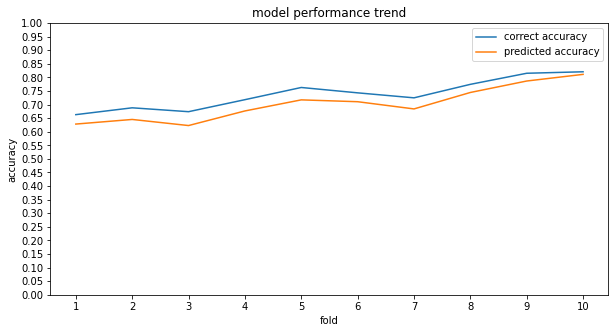

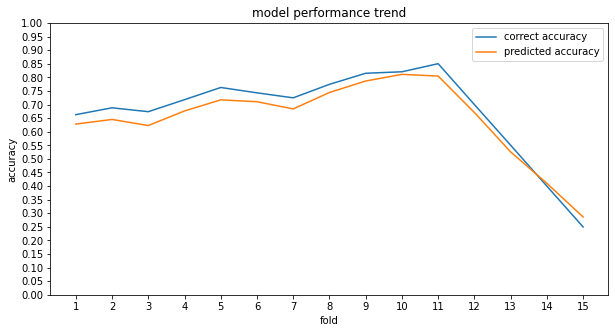

mean abs acc loss folds: 0.001395897388024351
mean abs acc loss folds extended: 0.0012630214774034944
sum abs acc loss folds: 0.3569000679809653
sum abs acc loss folds extended: 0.5031585713823256


In [92]:
sets_test(mm, mpp, train_X, validation_X, test_X, train_y, validation_y, test_y, mm_threshold, mpp_train_mpp_threshold, inverse_target=inverse_target)

test_folds_trend_pairs = folds_test(folds, mm, mpp,
                                    mm_threshold, mpp_train_mpp_threshold,
                                    inverse_target=inverse_target)
test_folds_extended_trend_pairs = folds_test(folds_extended, mm, mpp,
                                             mm_threshold, mpp_train_mpp_threshold,
                                             inverse_target=inverse_target)

mpp_diff_scores = accuracy_loss_test(test_folds_trend_pairs, test_folds_extended_trend_pairs)

In [93]:
mpp_results_df["dt+xgb"] = mpp_learn_scores + [mpp_train_mpp_gini, mpp_test_mpp_gini] + [mpp_diff_scores[0][0], mpp_diff_scores[1][0]] + [mpp_diff_scores[0][1], mpp_diff_scores[1][1]]

## Main XGBoost

### Set up

In [94]:
mm = xgb
mm_train_probas = xgb_train_probas
mm_validation_probas = xgb_validation_probas
mm_test_probas = xgb_test_probas
mm_threshold = xgb_train_threshold

In [95]:
folds = get_folds(test, nfolds, stratified=True)
avg_fold_len = round(len(test)/nfolds)


mm_test_mpp_targets = count_mpp_target_accuracy(mm_test_probas, test_y, mm_threshold)
mm_test_correct = test[mm_test_mpp_targets["mpp_target"] == 1]
mm_test_errors = test[mm_test_mpp_targets["mpp_target"] == 0]

folds_emulated = [
    pd.concat([mm_test_errors.sample(int(0.15*avg_fold_len)), mm_test_correct.sample(int(0.85*avg_fold_len))], axis=0),
    pd.concat([mm_test_errors.sample(int(0.30*avg_fold_len)), mm_test_correct.sample(int(0.70*avg_fold_len))], axis=0),
    pd.concat([mm_test_errors.sample(int(0.45*avg_fold_len)), mm_test_correct.sample(int(0.55*avg_fold_len))], axis=0),
    pd.concat([mm_test_errors.sample(int(0.60*avg_fold_len)), mm_test_correct.sample(int(0.40*avg_fold_len))], axis=0),
    pd.concat([mm_test_errors.sample(int(0.75*avg_fold_len)), mm_test_correct.sample(int(0.25*avg_fold_len))], axis=0)
]
folds_extended = folds + folds_emulated

In [96]:
validation_mpp_targets = count_mpp_target_accuracy(mm_validation_probas, validation_y, mm_threshold,
                                                   inverse=inverse_target)


validation_mpp = pd.concat([validation_X, validation_mpp_targets], axis=1)
validation_mpp_X = validation_mpp.drop(columns=[target_mpp])
validation_mpp_y = validation_mpp[target_mpp]

X_train_mpp, X_test_mpp, y_train_mpp, y_test_mpp = train_test_split(validation_mpp_X, validation_mpp_y, test_size=mpp_test_size, random_state=rand_state_mpp)

### Gradient boosting(main) + Logistic regression(mpp)

C:\Program Files\Python310\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
4250 fits failed out of a total of 17000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4250 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Program Files\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python310\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Program Files\Python310\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise V


	MPP parameters tuning:

GS CV train gini mean: 0.879
GS CV validation gini mean: 0.878
	gs cv is 5

	Best parameters:
 {'C': 719.6856730011514, 'max_iter': 400, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'lbfgs'}

	MPP model learning:
CV train gini mean: 0.877
CV test gini mean: 0.876
	cv is 3

Fit parameters:
 {'C': 719.6856730011514, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 400, 'multi_class': 'ovr', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

gini mpp train: 0.879
gini mpp test: 0.877 

CPU times: total: 5.72 s
Wall time: 1min 16s


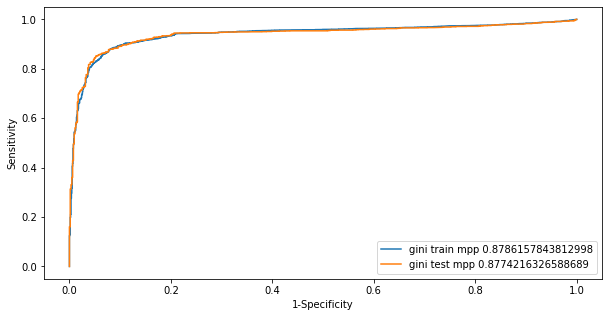

In [97]:
%%time


mpp = LogisticRegression(max_iter=800)
mpp, mpp_learn_scores = mpp_model_learn(mpp, lr_parameters_grid,
                                        X_train_mpp, y_train_mpp,
                                        validation_mpp_X, validation_mpp_y,
                                        cv_mpp, cv_gs,
                                        params_tuning=parameters_tuning)


mpp_train_mpp_probas, mpp_test_mpp_probas = apply_mpp_model(mpp, X_train_mpp, X_test_mpp)

mpp_train_mpp_gini, mpp_test_mpp_gini = count_sets_mpp_gini(mpp_train_mpp_probas, mpp_test_mpp_probas, y_train_mpp, y_test_mpp)

In [98]:
mpp_train_mpp_threshold, _ = calculate_threshold(mpp_train_mpp_probas, y_train_mpp, 0.02)

print("main model threshold:", mm_threshold)
print("mpp model threshold:", mpp_train_mpp_threshold)

KS stat max:


,interval,good,bad,bad_cum_prop,good_cum_prop,KS_stat
0,"[0.66, 0.68)",20,42,12.273361,92.111369,79.838008


main model threshold: 0.06
mpp model threshold: 0.68



accuracy main model train 0.733
predicted accuracy train 0.658
diff. 0.075

accuracy main model validation 0.735
predicted accuracy valdation 0.667
diff. 0.068

accuracy main model test 0.734
predicted accuracy test 0.656
diff. 0.078


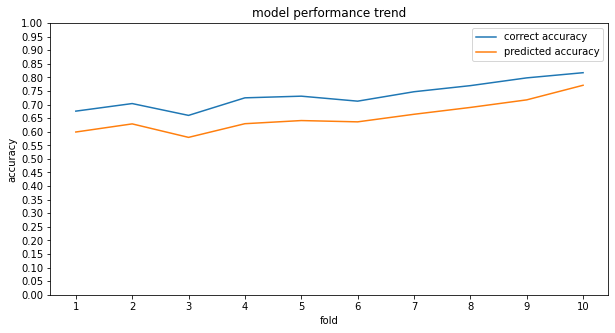

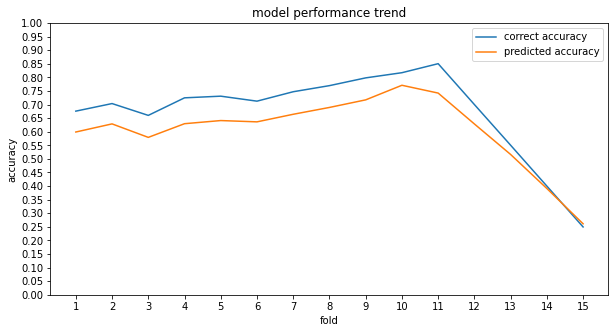

mean abs acc loss folds: 0.006293946736382204
mean abs acc loss folds extended: 0.005407311614805036
sum abs acc loss folds: 0.7838205302515298
sum abs acc loss folds extended: 1.0178341356937066


In [99]:
sets_test(mm, mpp, train_X, validation_X, test_X, train_y, validation_y, test_y, mm_threshold, mpp_train_mpp_threshold, inverse_target=inverse_target)

test_folds_trend_pairs = folds_test(folds, mm, mpp,
                                    mm_threshold, mpp_train_mpp_threshold,
                                    inverse_target=inverse_target)
test_folds_extended_trend_pairs = folds_test(folds_extended, mm, mpp,
                                             mm_threshold, mpp_train_mpp_threshold,
                                             inverse_target=inverse_target)

mpp_diff_scores = accuracy_loss_test(test_folds_trend_pairs, test_folds_extended_trend_pairs)

In [100]:
mpp_results_df["xgb+lr"] = mpp_learn_scores + [mpp_train_mpp_gini, mpp_test_mpp_gini] + [mpp_diff_scores[0][0], mpp_diff_scores[1][0]] + [mpp_diff_scores[0][1], mpp_diff_scores[1][1]]

### Gradient boosting(main) + Random forest(mpp)

rf Breiman samp size 3083

	MPP parameters tuning:

GS CV train gini mean: 0.986
GS CV validation gini mean: 0.920
	gs cv is 5

	Best parameters:
 {'max_depth': None, 'max_features': 'sqrt', 'max_samples': 3083, 'min_samples_split': 10, 'n_estimators': 100, 'random_state': 4}

	MPP model learning:
CV train gini mean: 0.983
CV test gini mean: 0.919
	cv is 3

Fit parameters:
 {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': 3083, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 4, 'verbose': 0, 'warm_start': False}

gini mpp train: 0.982
gini mpp test: 0.919 

CPU times: total: 16.9 s
Wall time: 29min 8s


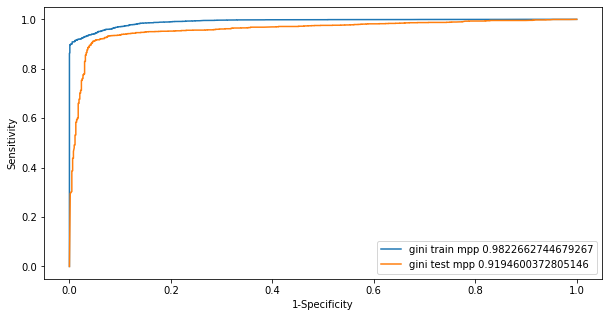

In [101]:
%%time


rf_parameters_grid_mpp = rf_parameters_grid
rf_parameters_grid_mpp.update(max_samples=[None, math.ceil(0.632*X_train_mpp.shape[0])])
print("rf Breiman samp size", math.ceil(0.632*X_train_mpp.shape[0]))

mpp = RandomForestClassifier(n_estimators=100, random_state=rand_state)
mpp, mpp_learn_scores = mpp_model_learn(mpp, rf_parameters_grid,
                                        X_train_mpp, y_train_mpp,
                                        validation_mpp_X, validation_mpp_y,
                                        cv_mpp, cv_gs,
                                        params_tuning=parameters_tuning)


mpp_train_mpp_probas, mpp_test_mpp_probas = apply_mpp_model(mpp, X_train_mpp, X_test_mpp)

mpp_train_mpp_gini, mpp_test_mpp_gini = count_sets_mpp_gini(mpp_train_mpp_probas, mpp_test_mpp_probas, y_train_mpp, y_test_mpp)

In [102]:
mpp_train_mpp_threshold, _ = calculate_threshold(mpp_train_mpp_probas, y_train_mpp, 0.02)

print("main model threshold:", mm_threshold)
print("mpp model threshold:", mpp_train_mpp_threshold)

KS stat max:


,interval,good,bad,bad_cum_prop,good_cum_prop,KS_stat
0,"[0.62, 0.64)",5,4,9.11271,96.287703,87.174993


main model threshold: 0.06
mpp model threshold: 0.64



accuracy main model train 0.733
predicted accuracy train 0.692
diff. 0.041

accuracy main model validation 0.735
predicted accuracy valdation 0.696
diff. 0.039

accuracy main model test 0.734
predicted accuracy test 0.691
diff. 0.043


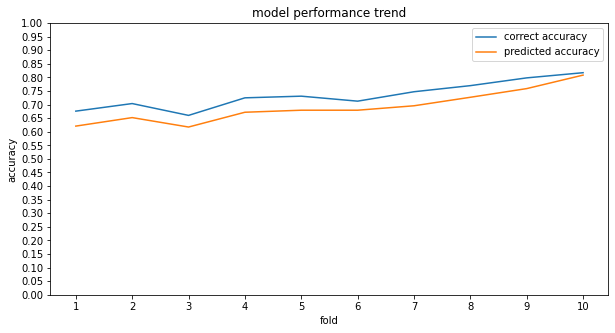

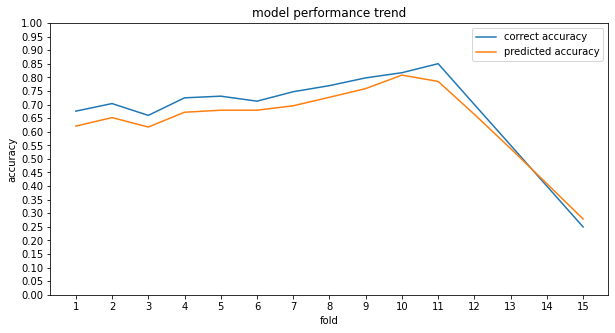

mean abs acc loss folds: 0.0020262579366968274
mean abs acc loss folds extended: 0.0017940798665396118
sum abs acc loss folds: 0.43031951053704964
sum abs acc loss folds extended: 0.5820201908091583


In [103]:
sets_test(mm, mpp, train_X, validation_X, test_X, train_y, validation_y, test_y, mm_threshold, mpp_train_mpp_threshold, inverse_target=inverse_target)

test_folds_trend_pairs = folds_test(folds, mm, mpp,
                                    mm_threshold, mpp_train_mpp_threshold,
                                    inverse_target=inverse_target)
test_folds_extended_trend_pairs = folds_test(folds_extended, mm, mpp,
                                             mm_threshold, mpp_train_mpp_threshold,
                                             inverse_target=inverse_target)

mpp_diff_scores = accuracy_loss_test(test_folds_trend_pairs, test_folds_extended_trend_pairs)

In [104]:
mpp_results_df["xgb+rf"] = mpp_learn_scores + [mpp_train_mpp_gini, mpp_test_mpp_gini] + [mpp_diff_scores[0][0], mpp_diff_scores[1][0]] + [mpp_diff_scores[0][1], mpp_diff_scores[1][1]]

### Gradient boosting(main) + CART(mpp)


	MPP parameters tuning:

GS CV train gini mean: 0.924
GS CV validation gini mean: 0.874
	gs cv is 5

	Best parameters:
 {'class_weight': None, 'criterion': 'gini', 'max_depth': 6, 'max_features': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 10, 'random_state': 4}

	MPP model learning:
CV train gini mean: 0.921
CV test gini mean: 0.873
	cv is 3

Fit parameters:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 6, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'random_state': 4, 'splitter': 'best'}

gini mpp train: 0.921
gini mpp test: 0.895 

CPU times: total: 391 ms
Wall time: 658 ms


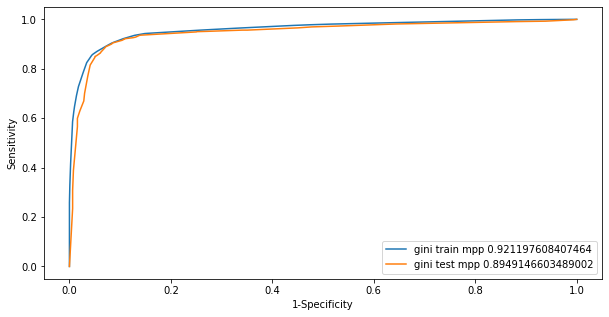

In [105]:
%%time


mpp = DecisionTreeClassifier(random_state=rand_state)
mpp, mpp_learn_scores = mpp_model_learn(mpp, dt_parameters_grid,
                                        X_train_mpp, y_train_mpp,
                                        validation_mpp_X, validation_mpp_y,
                                        cv_mpp, cv_gs,
                                        params_tuning=parameters_tuning)


mpp_train_mpp_probas, mpp_test_mpp_probas = apply_mpp_model(mpp, X_train_mpp, X_test_mpp)

mpp_train_mpp_gini, mpp_test_mpp_gini = count_sets_mpp_gini(mpp_train_mpp_probas, mpp_test_mpp_probas, y_train_mpp, y_test_mpp)

In [106]:
mpp_train_mpp_threshold, _ = calculate_threshold(mpp_train_mpp_probas, y_train_mpp, 0.02)

print("main model threshold:", mm_threshold)
print("mpp model threshold:", mpp_train_mpp_threshold)

KS stat max:


,interval,good,bad,bad_cum_prop,good_cum_prop,KS_stat
0,"[0.66, 0.68)",1,2,10.555973,89.404486,78.848513


main model threshold: 0.06
mpp model threshold: 0.68



accuracy main model train 0.733
predicted accuracy train 0.692
diff. 0.041

accuracy main model validation 0.735
predicted accuracy valdation 0.705
diff. 0.030

accuracy main model test 0.734
predicted accuracy test 0.695
diff. 0.039


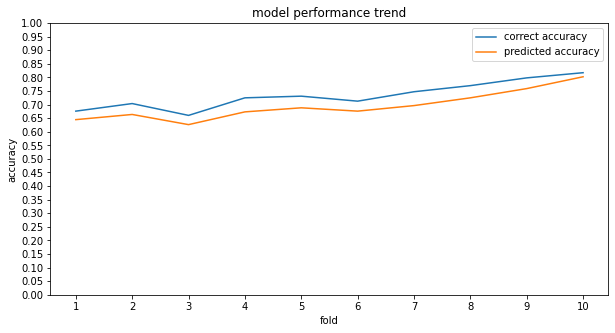

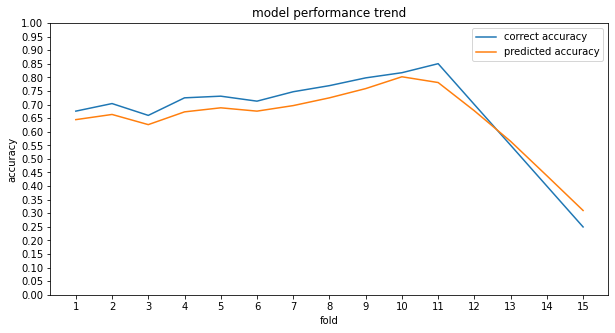

mean abs acc loss folds: 0.0015984076464028558
mean abs acc loss folds extended: 0.0017769753599925738
sum abs acc loss folds: 0.38681169272603677
sum abs acc loss folds extended: 0.5922538695967849


In [107]:
sets_test(mm, mpp, train_X, validation_X, test_X, train_y, validation_y, test_y, mm_threshold, mpp_train_mpp_threshold, inverse_target=inverse_target)

test_folds_trend_pairs = folds_test(folds, mm, mpp,
                                    mm_threshold, mpp_train_mpp_threshold,
                                    inverse_target=inverse_target)
test_folds_extended_trend_pairs = folds_test(folds_extended, mm, mpp,
                                             mm_threshold, mpp_train_mpp_threshold,
                                             inverse_target=inverse_target)

mpp_diff_scores = accuracy_loss_test(test_folds_trend_pairs, test_folds_extended_trend_pairs)

In [108]:
mpp_results_df["xgb+dt"] = mpp_learn_scores + [mpp_train_mpp_gini, mpp_test_mpp_gini] + [mpp_diff_scores[0][0], mpp_diff_scores[1][0]] + [mpp_diff_scores[0][1], mpp_diff_scores[1][1]]

### Gradient boosting(main) + XG Boost(mpp)

C:\Program Files\Python310\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
16200 fits failed out of a total of 32400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
16200 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Program Files\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\Python310\lib\site-packages\xgboost\core.py", line 532, in inner_f
    return f(**kwargs)
  File "C:\Program Files\Python310\lib\site-packages\xgboost\sklearn.py", line 1400, in fit
    self._Booster = train(
  File "C:\Program Files\Python310\lib\site-packages\xgboost\co


	MPP parameters tuning:

GS CV train gini mean: 0.961
GS CV validation gini mean: 0.916
	gs cv is 5

	Best parameters:
 {'gamma': 3, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 1000, 'seed': 4, 'subsample': 1}

	MPP model learning:
CV train gini mean: 0.962
CV test gini mean: 0.917
	cv is 3

Fit parameters:
 {'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': 0.5, 'booster': 'gbtree', 'callbacks': None, 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'gamma': 3, 'gpu_id': -1, 'grow_policy': 'depthwise', 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.1, 'max_bin': 256, 'max_cat_to_onehot': 4, 'max_delta_step': 0, 'max_depth': 8, 'max_leaves': 0, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 1000, 'n_jobs': 0, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 4, 'reg_alpha': 0

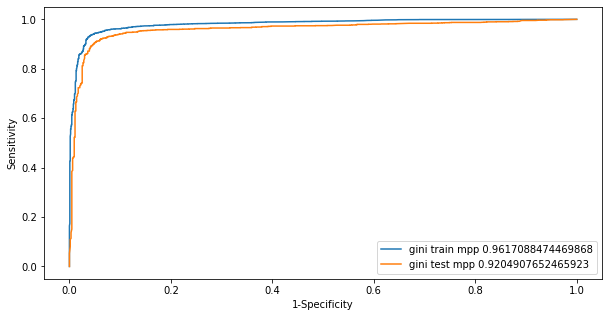

In [109]:
%%time


mpp = XGBClassifier(n_estimators=100, seed=rand_state)
mpp, mpp_learn_scores = mpp_model_learn(mpp, xgb_parameters_grid,
                                        X_train_mpp, y_train_mpp,
                                        validation_mpp_X, validation_mpp_y,
                                        cv_mpp, cv_gs,
                                        params_tuning=parameters_tuning)


mpp_train_mpp_probas, mpp_test_mpp_probas = apply_mpp_model(mpp, X_train_mpp, X_test_mpp)

mpp_train_mpp_gini, mpp_test_mpp_gini = count_sets_mpp_gini(mpp_train_mpp_probas, mpp_test_mpp_probas, y_train_mpp, y_test_mpp)

In [110]:
mpp_train_mpp_threshold, _ = calculate_threshold(mpp_train_mpp_probas, y_train_mpp, 0.02)

print("main model threshold:", mm_threshold)
print("mpp model threshold:", mpp_train_mpp_threshold)

KS stat max:


,interval,good,bad,bad_cum_prop,good_cum_prop,KS_stat
0,"[0.64, 0.66)",5,11,6.136681,95.514308,89.377627


main model threshold: 0.06
mpp model threshold: 0.66



accuracy main model train 0.733
predicted accuracy train 0.695
diff. 0.038

accuracy main model validation 0.735
predicted accuracy valdation 0.701
diff. 0.034

accuracy main model test 0.734
predicted accuracy test 0.694
diff. 0.040


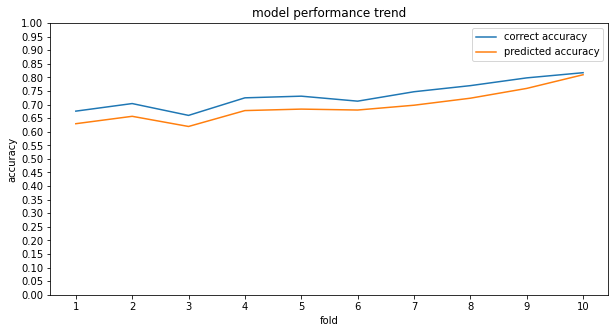

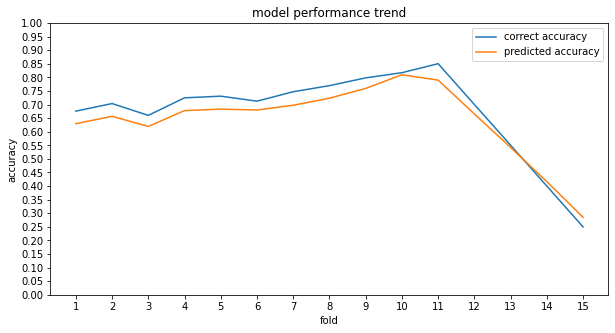

mean abs acc loss folds: 0.0017687528797171333
mean abs acc loss folds extended: 0.0016094214132323726
sum abs acc loss folds: 0.4031271244051666
sum abs acc loss folds extended: 0.558229165221493


In [111]:
sets_test(mm, mpp, train_X, validation_X, test_X, train_y, validation_y, test_y, mm_threshold, mpp_train_mpp_threshold, inverse_target=inverse_target)

test_folds_trend_pairs = folds_test(folds, mm, mpp,
                                    mm_threshold, mpp_train_mpp_threshold,
                                    inverse_target=inverse_target)
test_folds_extended_trend_pairs = folds_test(folds_extended, mm, mpp,
                                             mm_threshold, mpp_train_mpp_threshold,
                                             inverse_target=inverse_target)

mpp_diff_scores = accuracy_loss_test(test_folds_trend_pairs, test_folds_extended_trend_pairs)

In [112]:
mpp_results_df["xgb+xgb"] = mpp_learn_scores + [mpp_train_mpp_gini, mpp_test_mpp_gini] + [mpp_diff_scores[0][0], mpp_diff_scores[1][0]] + [mpp_diff_scores[0][1], mpp_diff_scores[1][1]]

## Results

In [113]:
mpp_results_df = prettify_results_df(mpp_results_df)

mpp_results_df

,lr+lr,lr+rf,lr+dt,lr+xgb,rf+lr,rf+rf,rf+dt,rf+xgb,dt+lr,dt+rf,dt+dt,dt+xgb,xgb+lr,gb+rf,xgb+dt,xgb+xgb
CV GS train gini,0.894,0.972,0.908,0.984,0.870,0.974,0.939,0.982,0.825,0.973,0.931,0.976,0.879,0.986,0.924,0.961
CV GS val gini,0.893,0.914,0.852,0.915,0.869,0.915,0.865,0.916,0.824,0.917,0.898,0.922,0.878,0.920,0.874,0.916
CV train gini,0.895,0.969,0.908,0.979,0.865,0.971,0.944,0.981,0.832,0.972,0.932,0.977,0.877,0.983,0.921,0.962
CV test gini,0.895,0.914,0.860,0.913,0.863,0.917,0.863,0.916,0.831,0.921,0.897,0.925,0.876,0.919,0.873,0.917
mpp train gini,0.894,0.969,0.903,0.979,0.869,0.969,0.935,0.981,0.825,0.972,0.926,0.974,0.879,0.982,0.921,0.962
mpp test gini,0.897,0.915,0.875,0.912,0.856,0.917,0.866,0.912,0.841,0.940,0.921,0.941,0.877,0.919,0.895,0.920
mean abs diff. f,0.002,0.002,0.002,0.001,0.007,0.004,0.001,0.001,0.007,0.002,0.001,0.001,0.006,0.002,0.002,0.002
mean abs diff. fe,0.002,0.002,0.002,0.001,0.006,0.003,0.002,0.001,0.006,0.002,0.001,0.001,0.005,0.002,0.002,0.002
sum abs diff. f,0.460,0.475,0.374,0.313,0.808,0.600,0.364,0.350,0.818,0.404,0.263,0.357,0.784,0.430,0.387,0.403
sum abs diff. fe,0.598,0.628,0.589,0.479,1.053,0.767,0.549,0.494,1.083,0.562,0.394,0.503,1.018,0.582,0.592,0.558
